In [131]:
#%%appyter init
from appyter import magic
magic.init(lambda _=globals: _())

In [132]:
%%appyter hide_code

{% do SectionField(
    name='primary',
    title='X2KTR (Expression to Kinases & Target Ranger)',
) %}

{% do DescriptionField(
    name='data_file_description',
    text='''
    Files should be a tsv/csv of the form:<br />
    <table class="table">
    <tr>
      <td>&nbsp;</td>
      <th>Patient 1 Tumor</th>
      <th>Patient 2 Tumor</th>
      <th>...</th>
    </tr>
    <tr>
      <th>Gene</th>
      <td>0</td>
      <td>200</td>
      <td>...</td>
    </tr>
    <tr>
      <th>Gene</th>
      <td>5</td>
      <td>180</td>
      <td>...</td>
    </tr>
    <tr>
      <th>...</th>
      <td>...</td>
      <td>...</td>
      <td>...</td>
    </tr>
    </table>''',
    section='primary',
) %}

{% set rna_file = FileField(
    name='rna_expr',
    label='RNA-seq tumor expression',
    description='Gene on the rows, samples on the columns',
    default='CPTAC3_HNSCC_tumor_counts.tsv',
    required=False,
    examples={
        'CPTAC3_HNSCC_tumor_counts.tsv': 'https://minio.dev.maayanlab.cloud/x2k-tr/CPTAC3_HNSCC_tumor_counts.tsv',
    },
    section='primary',
) %}


{% set prot_file = FileField(
    name='prot_expr',
    label='Protein tumor expression',
    description='Gene on the rows, samples on the columns',
    default='HNSCC_proteomics_tumor.tsv',
    required=False,
    examples={
        'HNSCC_proteomics_tumor.tsv': 'https://minio.dev.maayanlab.cloud/x2k-tr/HNSCC_proteomics_gene_abundance_log2_reference_intensity_normalized_Tumor.tsv',
    },
    section='primary',
) %}

{% set impute_protein_expr = BoolField(
    name='impute_protein_expr',
    label='Impute protein expression (averages)',
    default=True,
    section='primary',
) %}

{% set phospho_file = FileField(
    name='phospho_expr',
    label='Tumor protein phosphorylation',
    description='Phosphoproteins on the rows, samples on the columns',
    default='HSNCC_phospho_observed.tsv',
    required=False,
    examples={
        'HSNCC_phospho_observed.tsv': 'https://minio.dev.maayanlab.cloud/x2k-tr/HSNCC_phospho_observed.tsv',
    },
    section='primary',
) %}

{% set impute_phospho_expr = BoolField(
    name='impute_phospho_expr',
    label='Impute protein phosphorylation (averages)',
    default=True,
    section='primary',
) %}

{% set meta_file = FileField(
    name='meta',
    label='Sample metadata',
    description='Samples on the rows, metadata on the columns',
    default='HNSCC_meta.txt',
    required=True,
    examples={
        'HNSCC_meta.txt': 'https://minio.dev.maayanlab.cloud/x2k-tr/HNSCC_meta.txt',
    },
    section='primary',
) %}

{% set membrane_screener_ = TabField(
    name='membrane_screener',
    label='Prioritize membrane genes',
    description='Use a list of genes that encode cell surface proteins to identify membrane. Only human currently supported.',
    default='Yes',
    section='primary',
    choices={
     'Yes': [
        ChoiceField(
                name='membrane_list',
                label='Membrane gene list',
                description='Choose the source for list of membrane genes.',
                choices={
                    'COMPARTMENTS + Human Protein Atlas': "'https://appyters.maayanlab.cloud/storage/Tumor_Gene_Target_Screener/surfaceome.csv'",
                    'Membranome': "'https://lomize-group-membranome.herokuapp.com/proteins?fileFormat=csv'",
                },
                default='COMPARTMENTS + Human Protein Atlas',
            ),
    ],
    'No': [
    ]
    }
) %}

{% set membrane_screener_list = membrane_screener_.value[0] %}

{% set membrane_screener = membrane_screener_.raw_value == 'Yes' %}

{% set normalize_to_background = BoolField(
    name='normalize_to_background',
    label='Normalize to background distribution (Target Identification)',
    default=True,
    section='primary',
) %}

## X2KTR
### Expression to Kinases & Target Ranger
Finding targets and key to cell signaling pathways that are uniquely activated in tumor cells while absent from all normal tissues and cell types remains a significant challenge. In addition, targets identified from analyzing transcriptomics do not ensure that the targets are also expressed at the protein level. Furthermore, heterogeneity within the tumor, across patients of the same cancer type, and across cancers, underscore the need for subtype-specific personalized target identification. Our analysis and workflows address some of these challenges by combining phosphoproteomics, proteomics, and transcriptomics with comprehensive normal tissue and cell type atlases to identify safer targets for cancer subtypes. 

In [133]:
from helpers import *
import os
import re
import qnorm
from tqdm import tqdm
import numpy as np
import pandas as pd

from matplotlib import cm
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import HTML, display, Markdown, FileLink
from matplotlib.gridspec import GridSpec
from matplotlib_venn import venn2
from maayanlab_bioinformatics.normalization import zscore_normalize, log2_normalize
from scipy.stats import zscore
from maayanlab_bioinformatics.dge import limma_voom_differential_expression
from maayanlab_bioinformatics.harmonization.ncbi_genes import ncbi_genes_lookup

os.makedirs('results', exist_ok=True)
os.makedirs('figures', exist_ok=True)

lookup = ncbi_genes_lookup(organism='Mammalia/Homo_sapiens')

import sys
import contextlib
@contextlib.contextmanager
def suppress_output(stdout=True, stderr=True, dest=os.devnull):
    ''' Usage:
    with suppress_output():
        print('hi')
    '''
    dev_null = open(dest, 'a')
    if stdout:
        _stdout = sys.stdout
        sys.stdout = dev_null
    if stderr:
        _stderr = sys.stderr
        sys.stderr = dev_null
    try:
        yield
    finally:
        if stdout:
            sys.stdout = _stdout
        if stderr:
            sys.stderr = _stderr

In [134]:
%%appyter code_exec
has_rna_file = {{ rna_file }} != ''
has_prot_file = {{ prot_file }} != ''
has_phospho_file = {{ phospho_file }} != ''
has_meta_file = {{ meta_file }} != ''

```python
has_rna_file = 'CPTAC3_HNSCC_tumor_counts.tsv' != ''
has_prot_file = 'HNSCC_proteomics_tumor.tsv' != ''
has_phospho_file = 'HSNCC_phospho_observed.tsv' != ''
has_meta_file = 'HNSCC_meta.txt' != ''
```

In [135]:
%%appyter code_exec
if has_rna_file:
    rna_df = read_table({{ rna_file }})
    rna_filename = {{ rna_file }}.split('.')[0]
if has_prot_file:
    prot_df = read_table({{ prot_file }})
    prot_filename = {{ prot_file }}.split('.')[0]
if has_phospho_file:
    phospho_df = read_table({{ phospho_file }})
    phospho_filename = {{ phospho_file }}.split('.')[0]
if has_meta_file:
    meta_df = read_table({{ meta_file }})

```python
if has_rna_file:
    rna_df = read_table('CPTAC3_HNSCC_tumor_counts.tsv')
    rna_filename = 'CPTAC3_HNSCC_tumor_counts.tsv'.split('.')[0]
if has_prot_file:
    prot_df = read_table('HNSCC_proteomics_tumor.tsv')
    prot_filename = 'HNSCC_proteomics_tumor.tsv'.split('.')[0]
if has_phospho_file:
    phospho_df = read_table('HSNCC_phospho_observed.tsv')
    phospho_filename = 'HSNCC_phospho_observed.tsv'.split('.')[0]
if has_meta_file:
    meta_df = read_table('HNSCC_meta.txt')
```

# TRANSCRIPTOMICS

#### Cluster Samples from RNA-seq Expression for Target Identification

Grouping patients together who share similar vectors of expression may lead to identification of targets specific to smaller subsets of patients. Clustering is performed on the 1000 most variable genes using the leiden community algorthim [1]. 

In [136]:
rna_df.index = rna_df.index.map(lambda g: g.split('.')[0])
rna_df.index = rna_df.index.map(lambda g: lookup(g) if lookup(g) else g)

/Users/giacomomarino/X2KTR/venv/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca


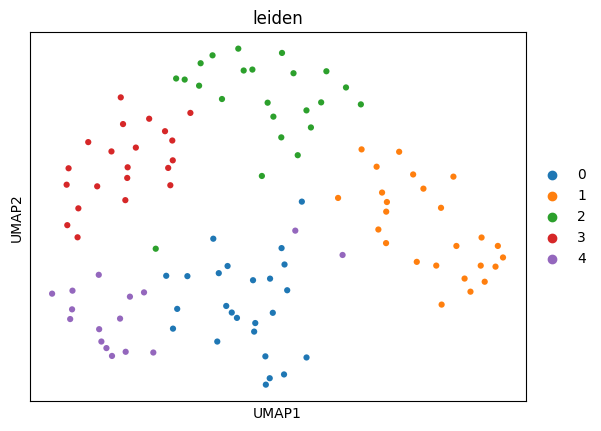

In [140]:
import scanpy as sc
adata = sc.AnnData(log2_normalize(rna_df).T.values, dtype="int")
adata.var['gene_names'] = rna_df.index.values
adata.obs['samples'] = rna_df.columns.values
# Sort genes by variance
adata.var['var_rank'] = (-np.var(adata.X, axis=0, dtype="float")).argsort()
adata = adata[:, adata.var.var_rank < 5000]

min_dist=0.01
n_neighbors=10
resolution=1
# UMAP
sc.pp.pca(adata)
sc.pp.neighbors(adata, n_neighbors=n_neighbors)  # create neighborhood graph
sc.tl.umap(adata, min_dist=min_dist, alpha=0.1)  # embed umap based on neighborhood graph
sc.tl.leiden(adata, resolution=resolution)  # clustering
sc.pl.umap(adata, color="leiden", size=80)

In [141]:
leiden_df = pd.DataFrame([adata.obs['leiden'], adata.obs['samples']]).T.set_index('samples')
clusters = list(leiden_df['leiden'].unique())
leiden_df.value_counts()

leiden
0         25
1         25
2         23
3         21
4         16
Name: count, dtype: int64

In [142]:
cluster_dges = {}
for c in sorted(clusters):
    cluster_dges[c] = {}
    cluster_samples = list(leiden_df[leiden_df['leiden'] == c].index.values)
    other_samples = [s for s in rna_df.columns if s not in cluster_samples]

    with suppress_output():
        dge = limma_voom_differential_expression(
            rna_df[other_samples], rna_df[cluster_samples],
            voom_design=True,
        )
    dge_filename = f'results/{rna_filename}_cluster_{c}_vs_rest_dge_limma.tsv'
    dge.sort_values(by="adj.P.Val", ascending=True).to_csv(dge_filename, sep='\t')
    sig_dge = dge[dge['adj.P.Val'] < 0.01]
    cluster_dges[c]['up'] = list(sig_dge[sig_dge['logFC'] > 0].index.values)
    cluster_dges[c]['down'] = list(sig_dge[sig_dge['logFC'] < 0].index.values)
    print('Identified', len(cluster_dges[c]['up']), 'upregulated genes and', len(cluster_dges[c]['down']), 'downregulated genes for cluster', c)
    display(FileLink(dge_filename, result_html_prefix=f'Differential expression for cluster {c}: '))

Identified 903 upregulated genes and 158 downregulated genes for cluster 0


/Users/giacomomarino/X2KTR/results/CPTAC3_HNSCC_tumor_counts_cluster_0_vs_rest_dge_limma.tsv

Identified 1861 upregulated genes and 1371 downregulated genes for cluster 1


/Users/giacomomarino/X2KTR/results/CPTAC3_HNSCC_tumor_counts_cluster_1_vs_rest_dge_limma.tsv

Identified 19075 upregulated genes and 1640 downregulated genes for cluster 2


/Users/giacomomarino/X2KTR/results/CPTAC3_HNSCC_tumor_counts_cluster_2_vs_rest_dge_limma.tsv

Identified 818 upregulated genes and 1348 downregulated genes for cluster 3


/Users/giacomomarino/X2KTR/results/CPTAC3_HNSCC_tumor_counts_cluster_3_vs_rest_dge_limma.tsv

Identified 1508 upregulated genes and 775 downregulated genes for cluster 4


/Users/giacomomarino/X2KTR/results/CPTAC3_HNSCC_tumor_counts_cluster_4_vs_rest_dge_limma.tsv

In [143]:
from maayanlab_bioinformatics.api import enrichr_link_from_genes

enrichr_lists = {}

for c in sorted(clusters):
    try:
        up = enrichr_link_from_genes(cluster_dges[c]['up'], f'Upregulated genes in cluster {c}')
        dn = enrichr_link_from_genes(cluster_dges[c]['down'], f'Downregulated genes in cluster {c}')
        print(f'Upregulated genes in cluster {c}:', up['link'])
        print(f'Downregulated genes in cluster {c}:', dn['link'], '\n')
        enrichr_lists[c] = (up, dn)
    except Exception as e:
        print(f'Error processing cluster {c}:', e)


Upregulated genes in cluster 0: https://maayanlab.cloud/Enrichr/enrich?dataset=81901813631c9290ad4eb88d9d4c056b
Downregulated genes in cluster 0: https://maayanlab.cloud/Enrichr/enrich?dataset=db1570c56626377161328b75c4b95d5e 

Upregulated genes in cluster 1: https://maayanlab.cloud/Enrichr/enrich?dataset=8c252b9cba399468c310418bc1b4d25e
Downregulated genes in cluster 1: https://maayanlab.cloud/Enrichr/enrich?dataset=7baed749df0be4d91f4db691b0ce6f3d 

Upregulated genes in cluster 2: https://maayanlab.cloud/Enrichr/enrich?dataset=6d1aa2975d5cbec5165781701a394dcc
Downregulated genes in cluster 2: https://maayanlab.cloud/Enrichr/enrich?dataset=23f3d03830b01fab58611dc93b365c74 

Upregulated genes in cluster 3: https://maayanlab.cloud/Enrichr/enrich?dataset=54a9a73f0e811973e64b8d175241512d
Downregulated genes in cluster 3: https://maayanlab.cloud/Enrichr/enrich?dataset=eb264c408a03c4962922fd51d8a25c30 

Upregulated genes in cluster 4: https://maayanlab.cloud/Enrichr/enrich?dataset=34ed76e24

### Cluster 0

#### Upregulated genes

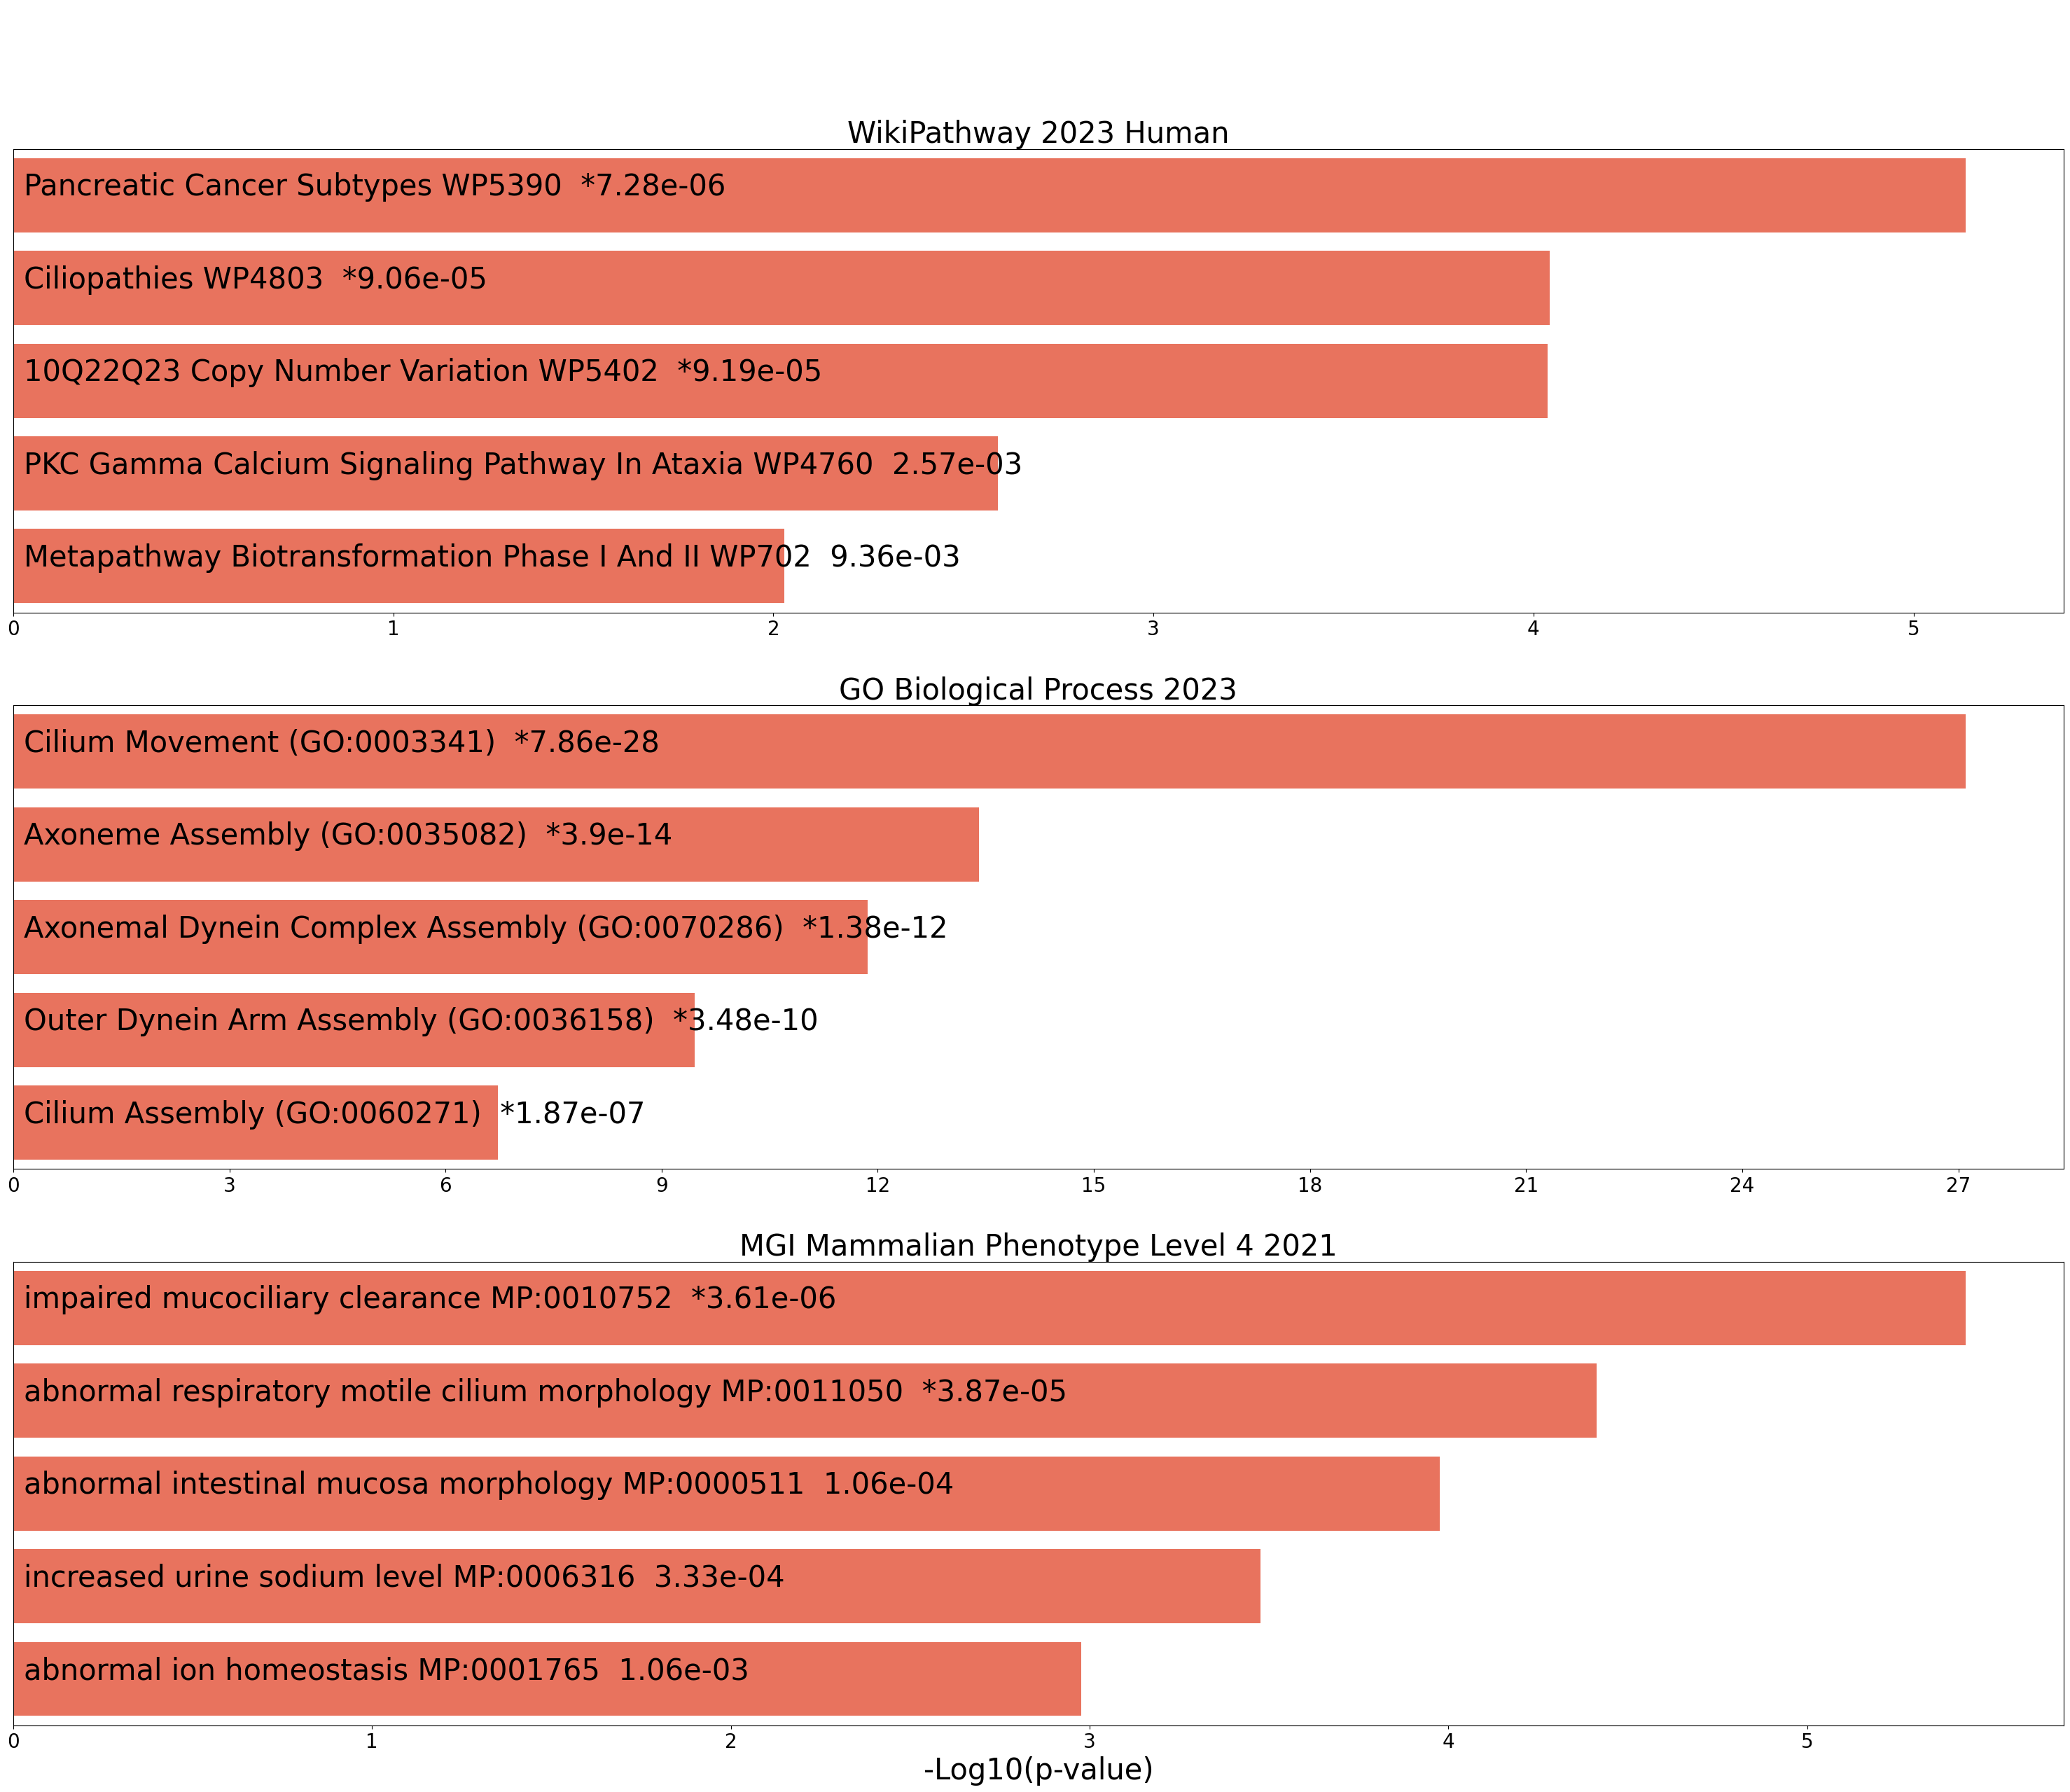

/Users/giacomomarino/X2KTR/figures/enrichr_up_cluster_0.png

/Users/giacomomarino/X2KTR/figures/enrichr_up_cluster_0.svg

#### Downregulated genes

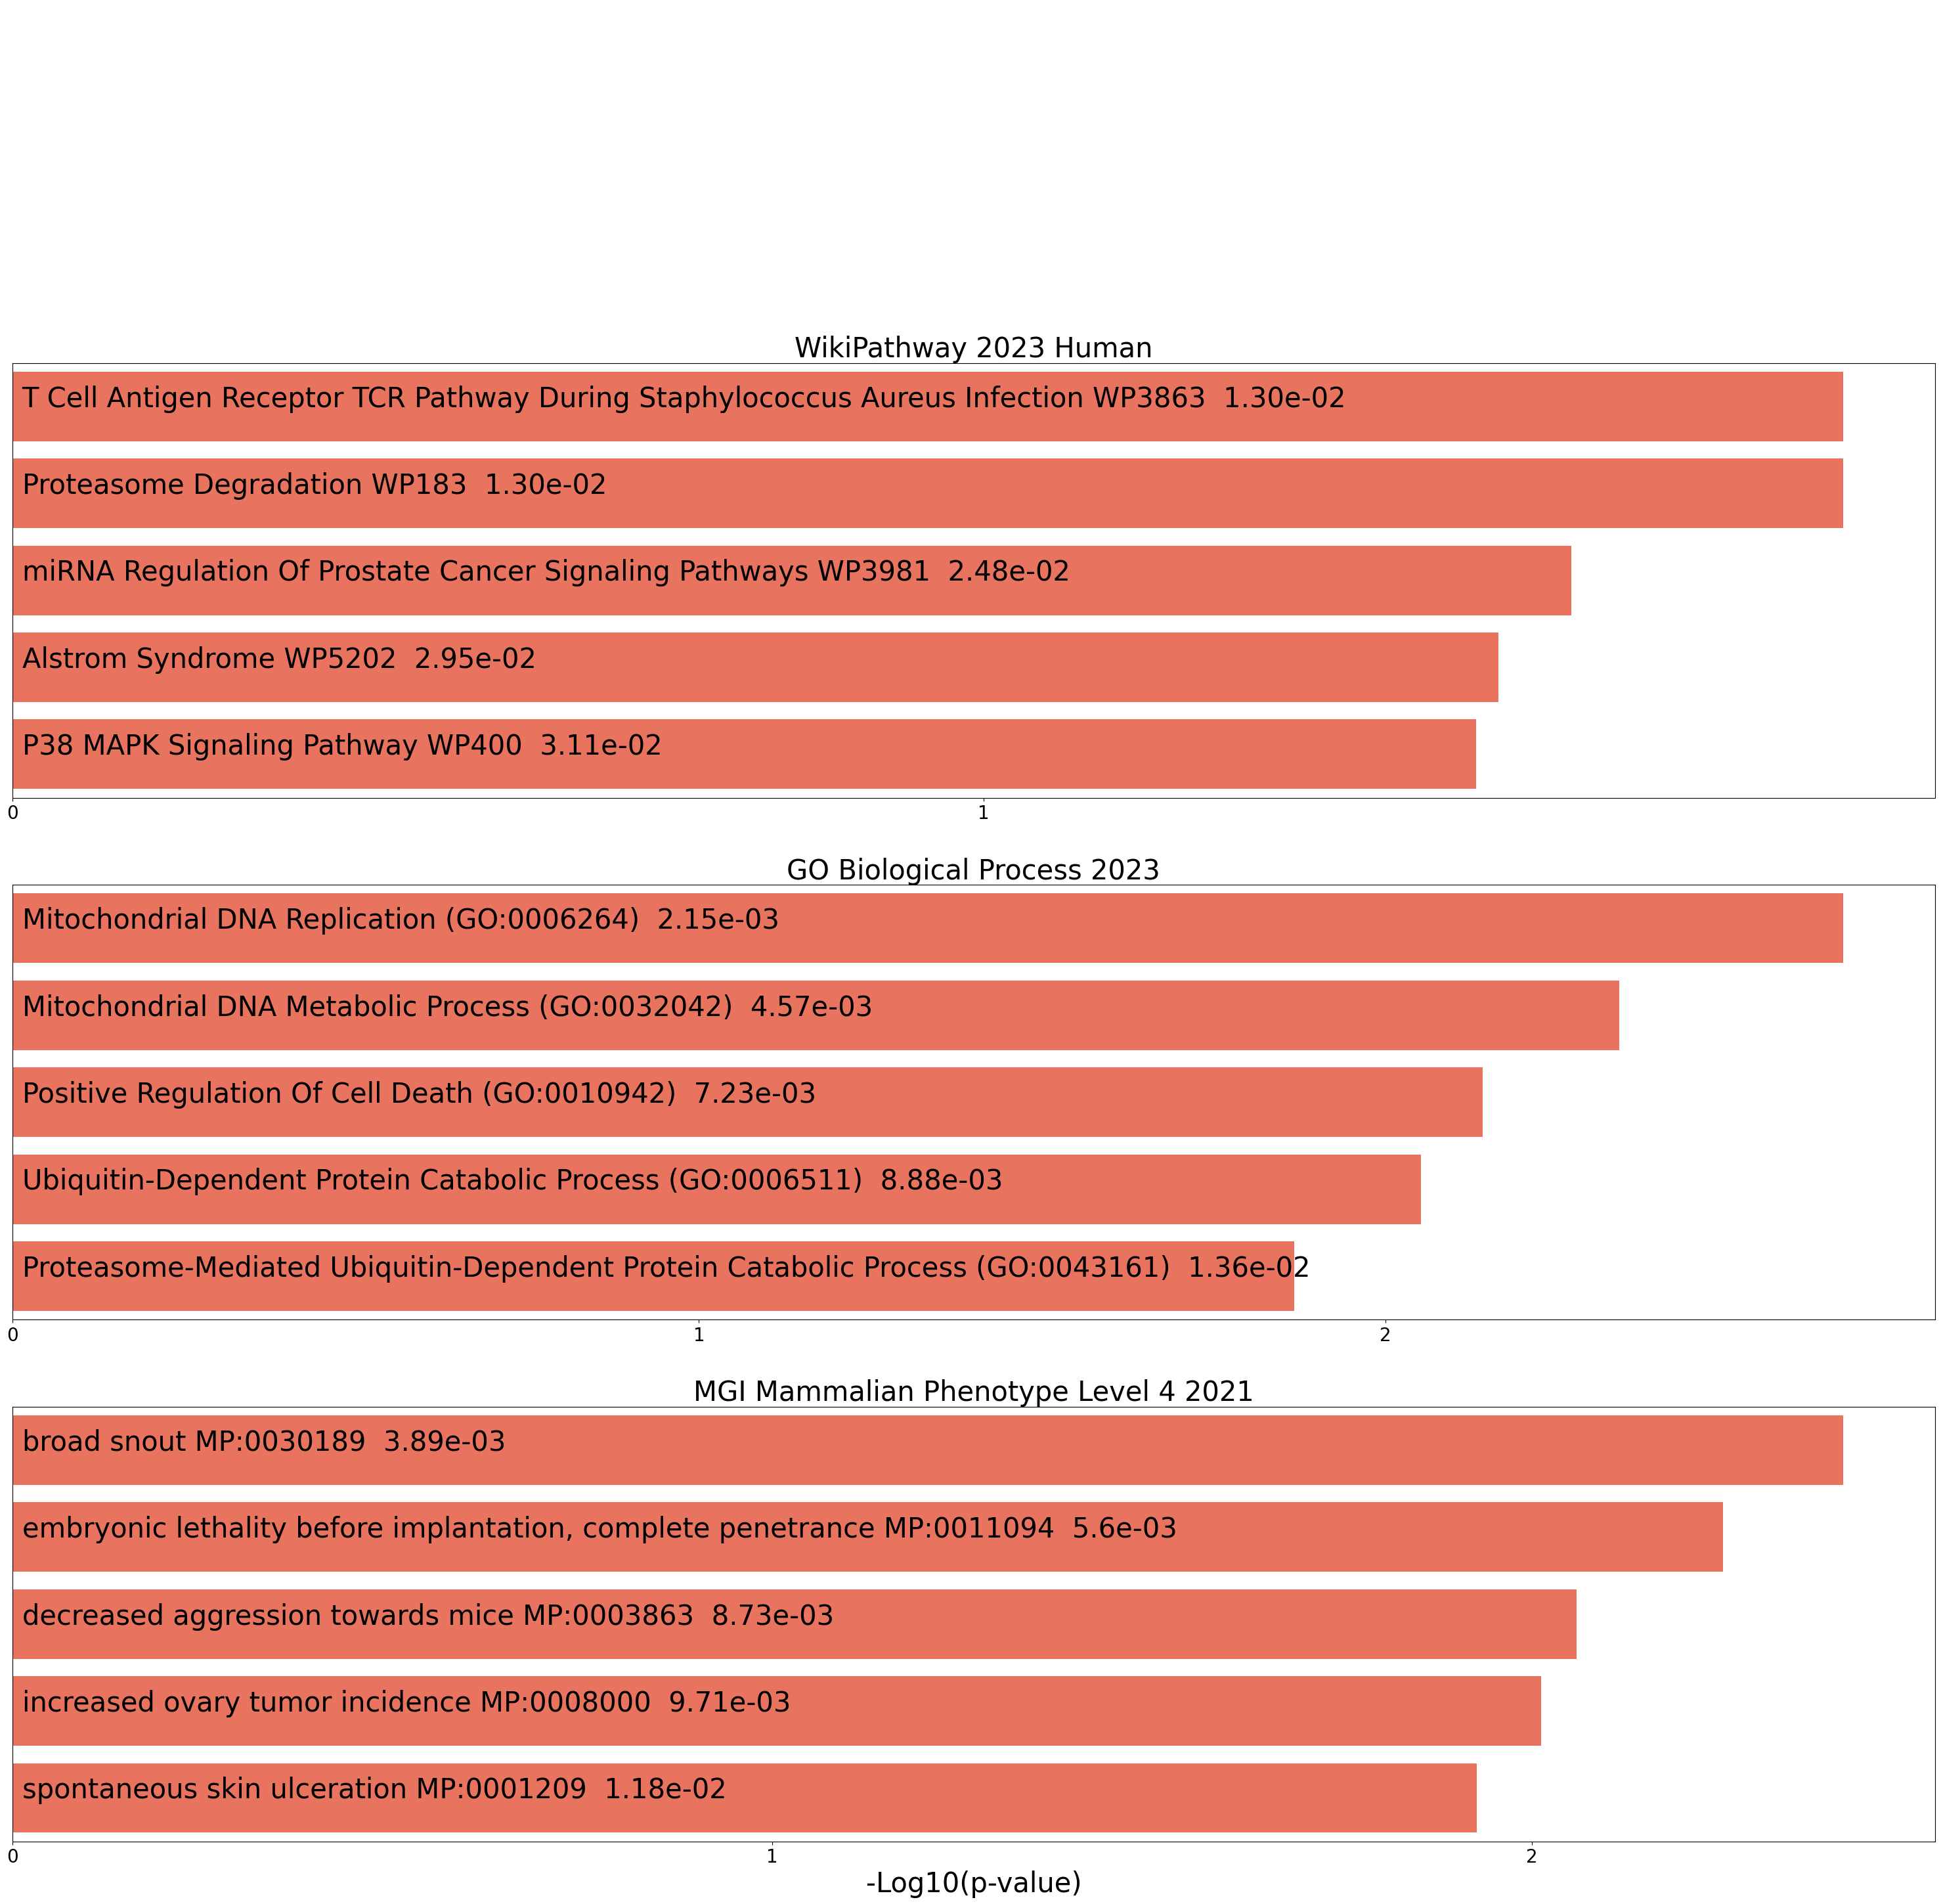

/Users/giacomomarino/X2KTR/figures/enrichr_dn_cluster_0.png

/Users/giacomomarino/X2KTR/figures/enrichr_dn_cluster_0.svg

### Cluster 1

#### Upregulated genes

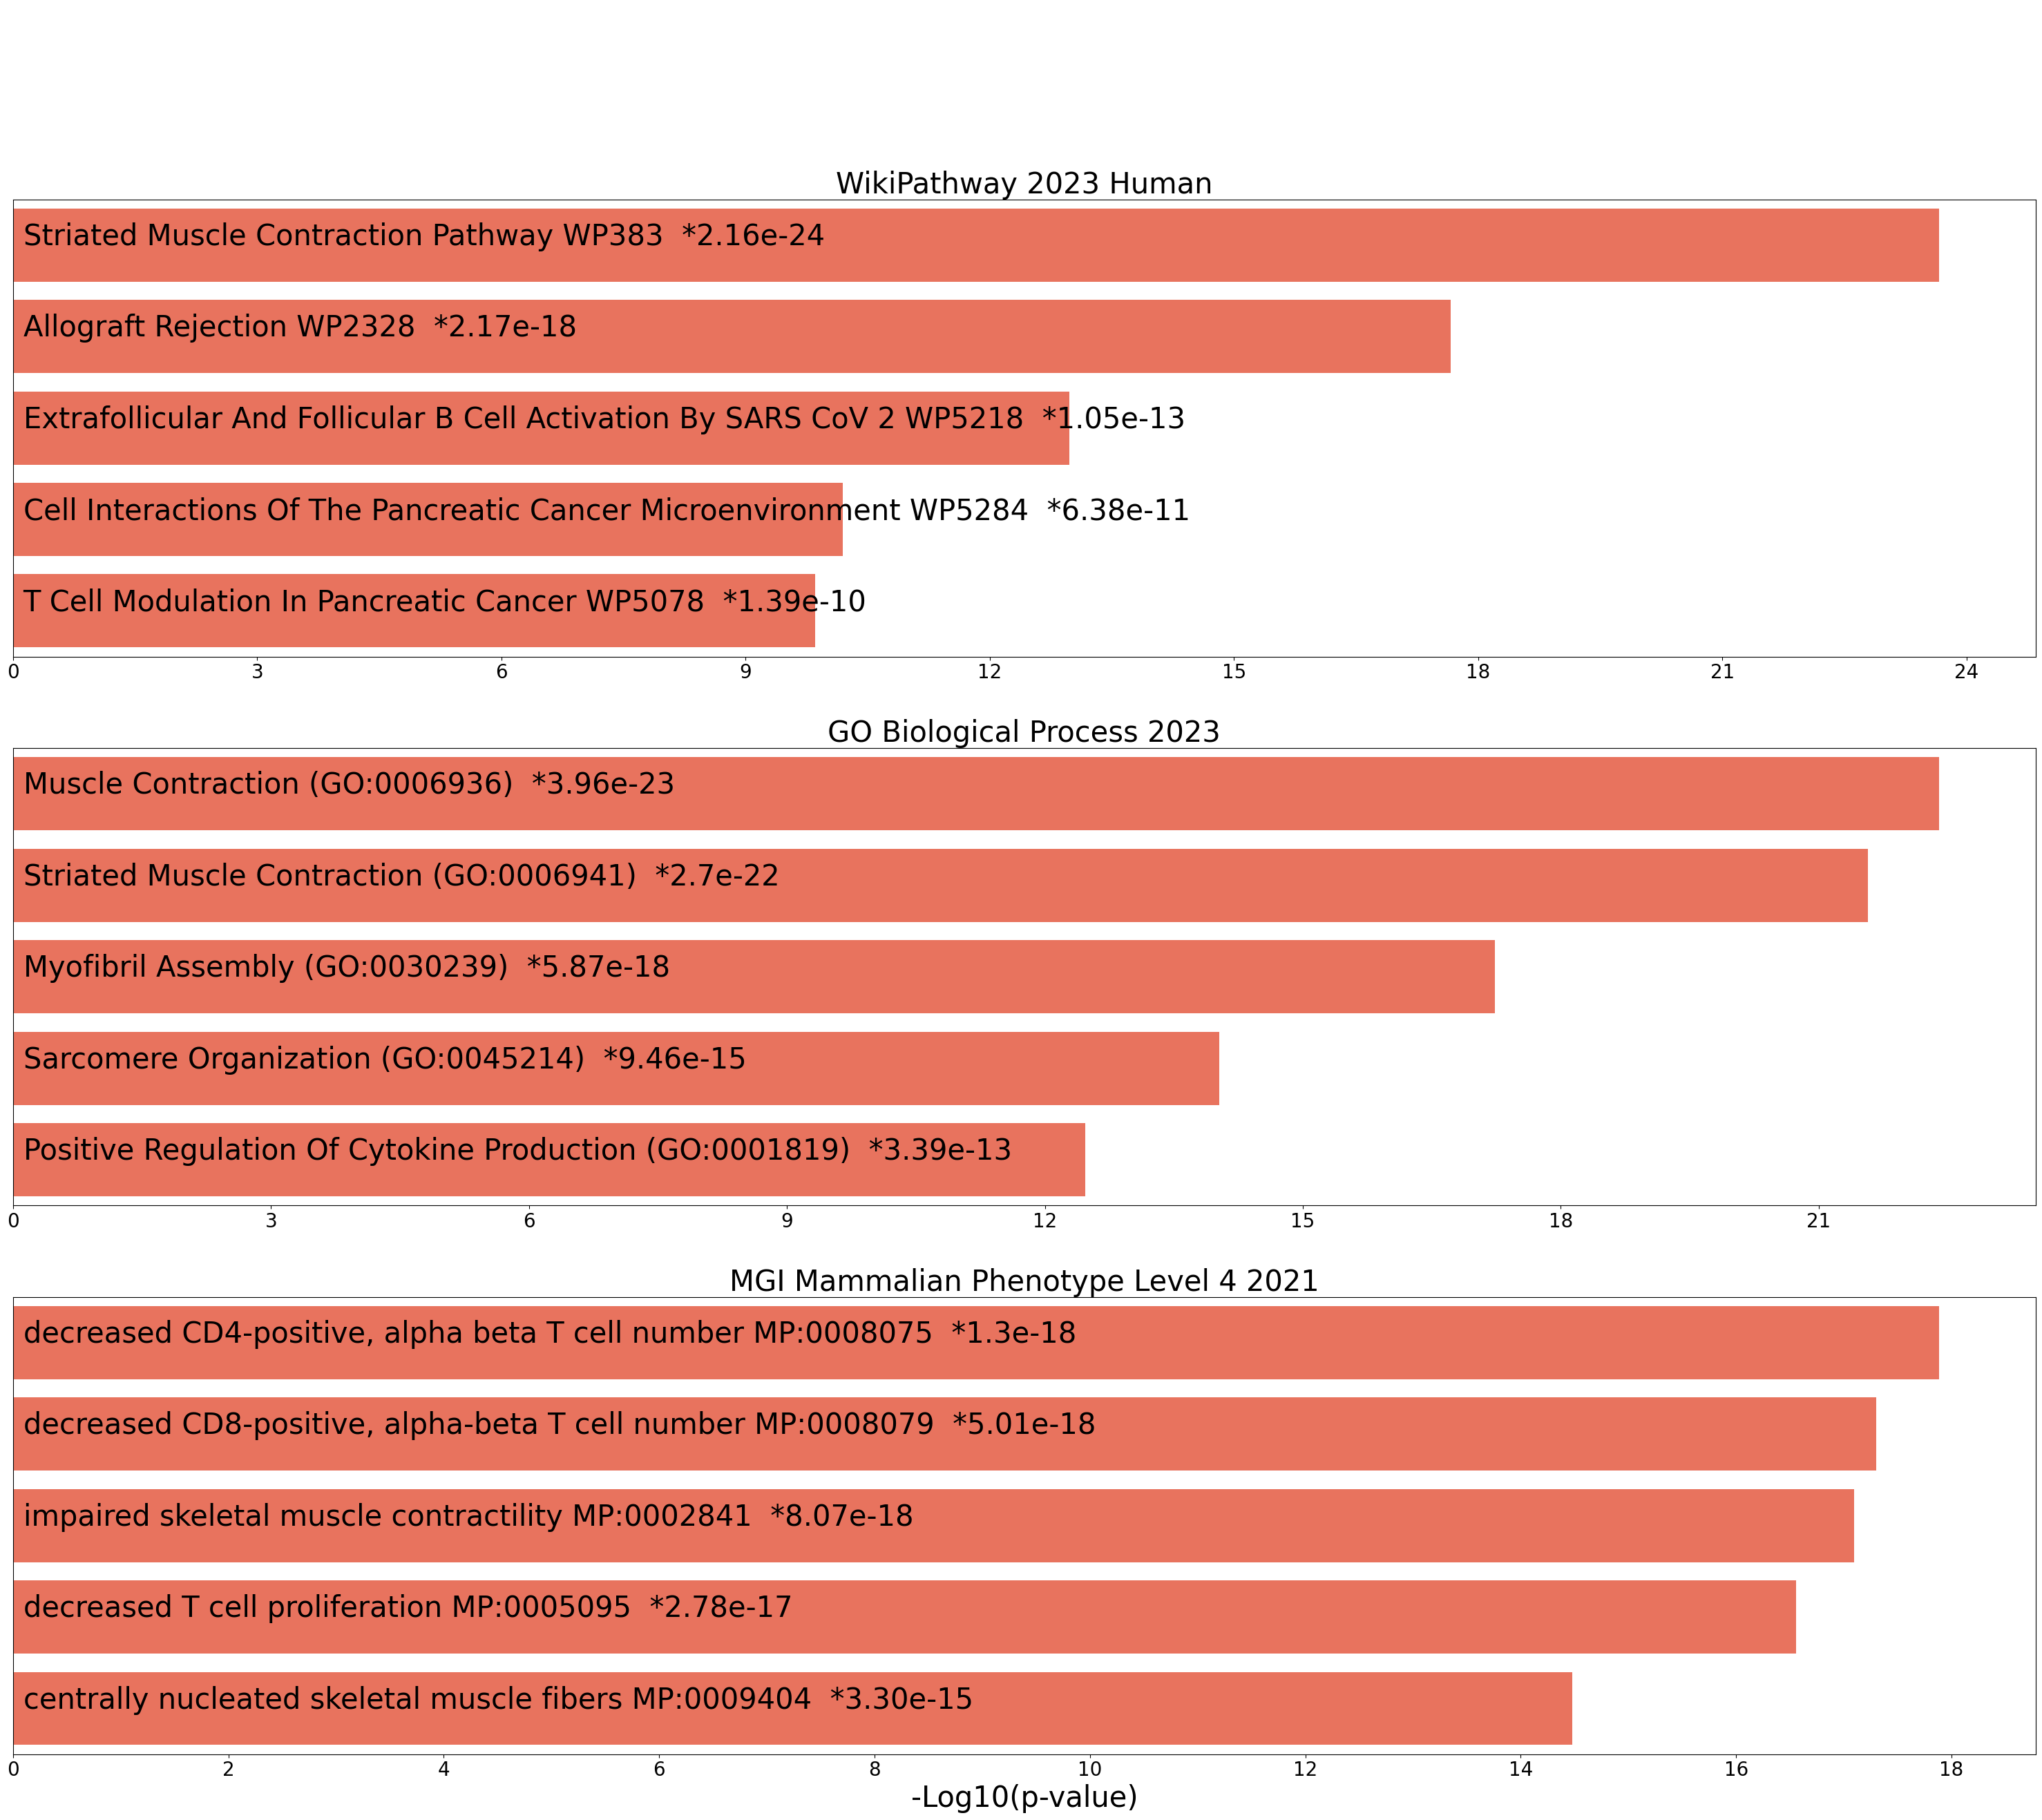

/Users/giacomomarino/X2KTR/figures/enrichr_up_cluster_1.png

/Users/giacomomarino/X2KTR/figures/enrichr_up_cluster_1.svg

#### Downregulated genes

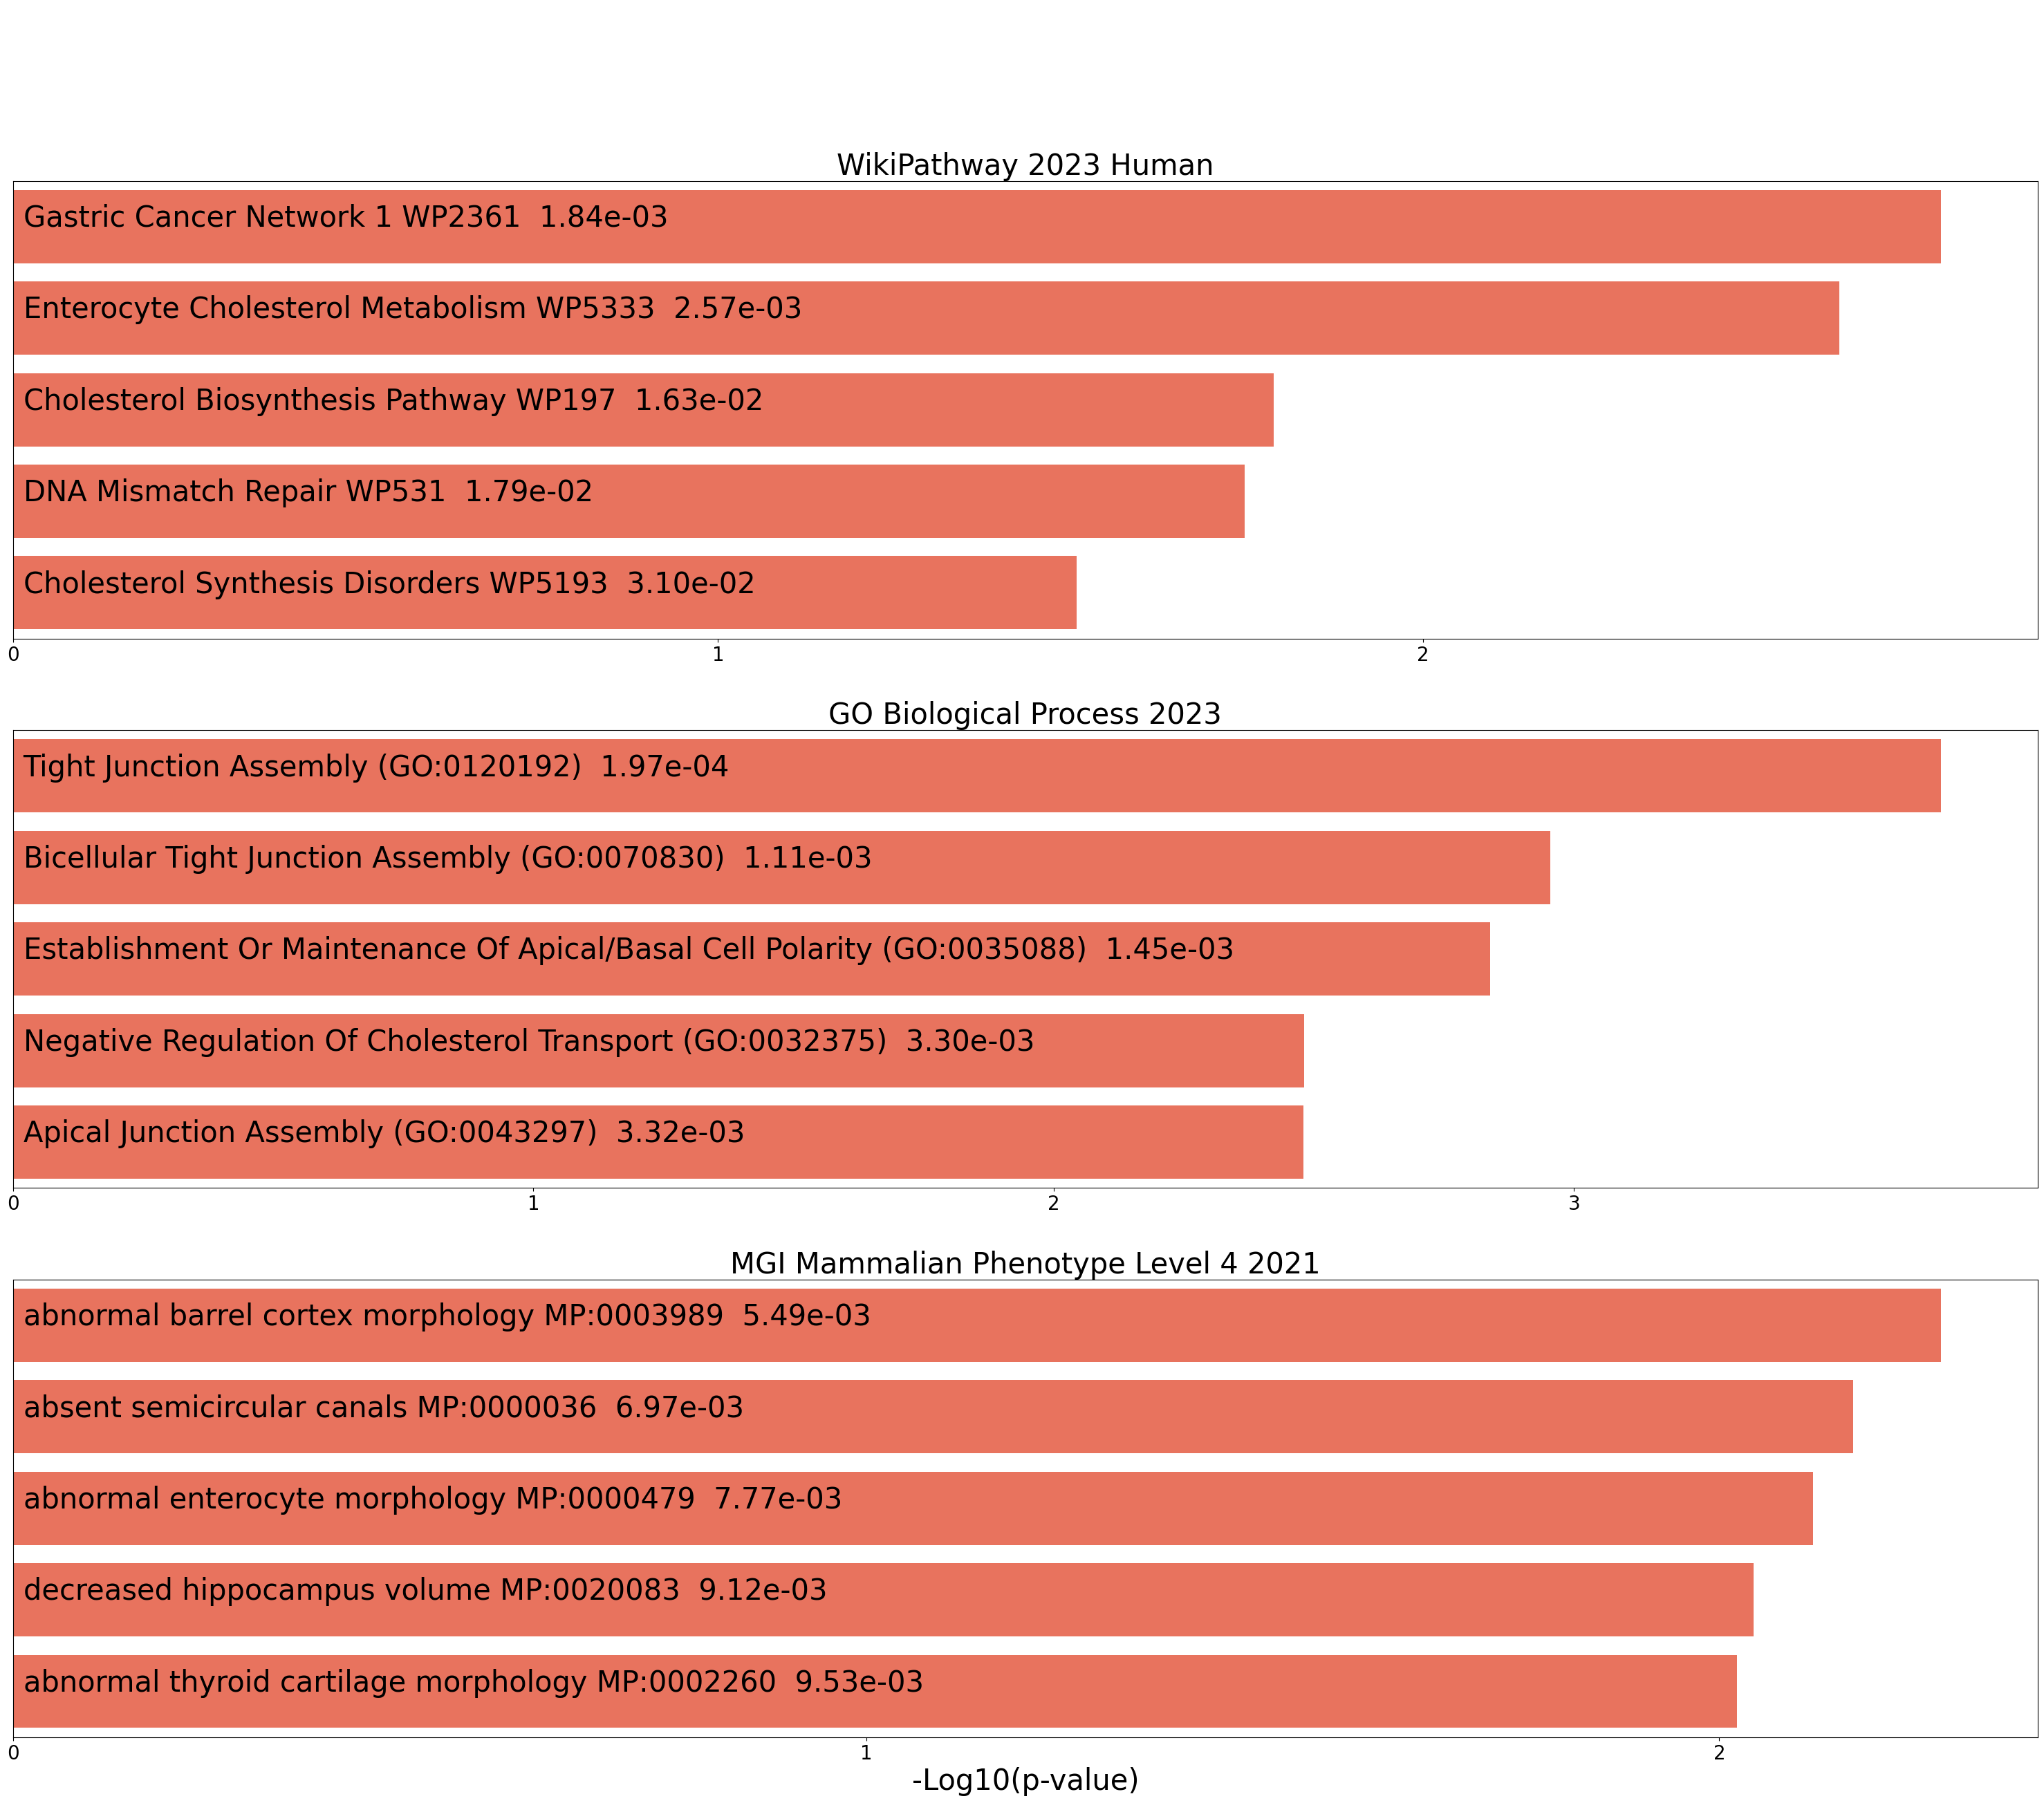

/Users/giacomomarino/X2KTR/figures/enrichr_dn_cluster_1.png

/Users/giacomomarino/X2KTR/figures/enrichr_dn_cluster_1.svg

### Cluster 2

#### Upregulated genes

<!DOCTYPE html>
<html lang="en">
<head>
	<title>Enrichr</title>
	<meta http-equiv="Content-Type" content="text/html;charset=UTF-8">
	<meta name="author" content="Edward Y. Chen"/>
	<meta name="viewport" content="width=750">
	<link rel="shortcut icon" type="image/x-icon" href="favicon.ico"/>
	<link rel="icon" type="image/ico" href="favicon.ico"/>
	<link rel="stylesheet" type="text/css" href="css/reset-min.css"/>
	<link href='https://fonts.googleapis.com/css?family=Droid+Sans' rel='stylesheet' type='text/css'/>
	<link rel="stylesheet" type="text/css" href="css/common.css"/>
	<link rel="stylesheet" type="text/css" href="css/login.css"/>
</head>
<body>
	<div id="logo">
		<a href="index.html"><img src="images/enrichr-icon.png"/><span>En</span><span class="red">rich</span><span>r</span></a>
	</div>
	<div class="clear"></div>
	<div id="content" class="beveled">
		<div class="title">Error</div>
		<div>
			Failed to perform get. (400)
		</div>
	</div>
</body>
</html>
Error processing cluster 2 

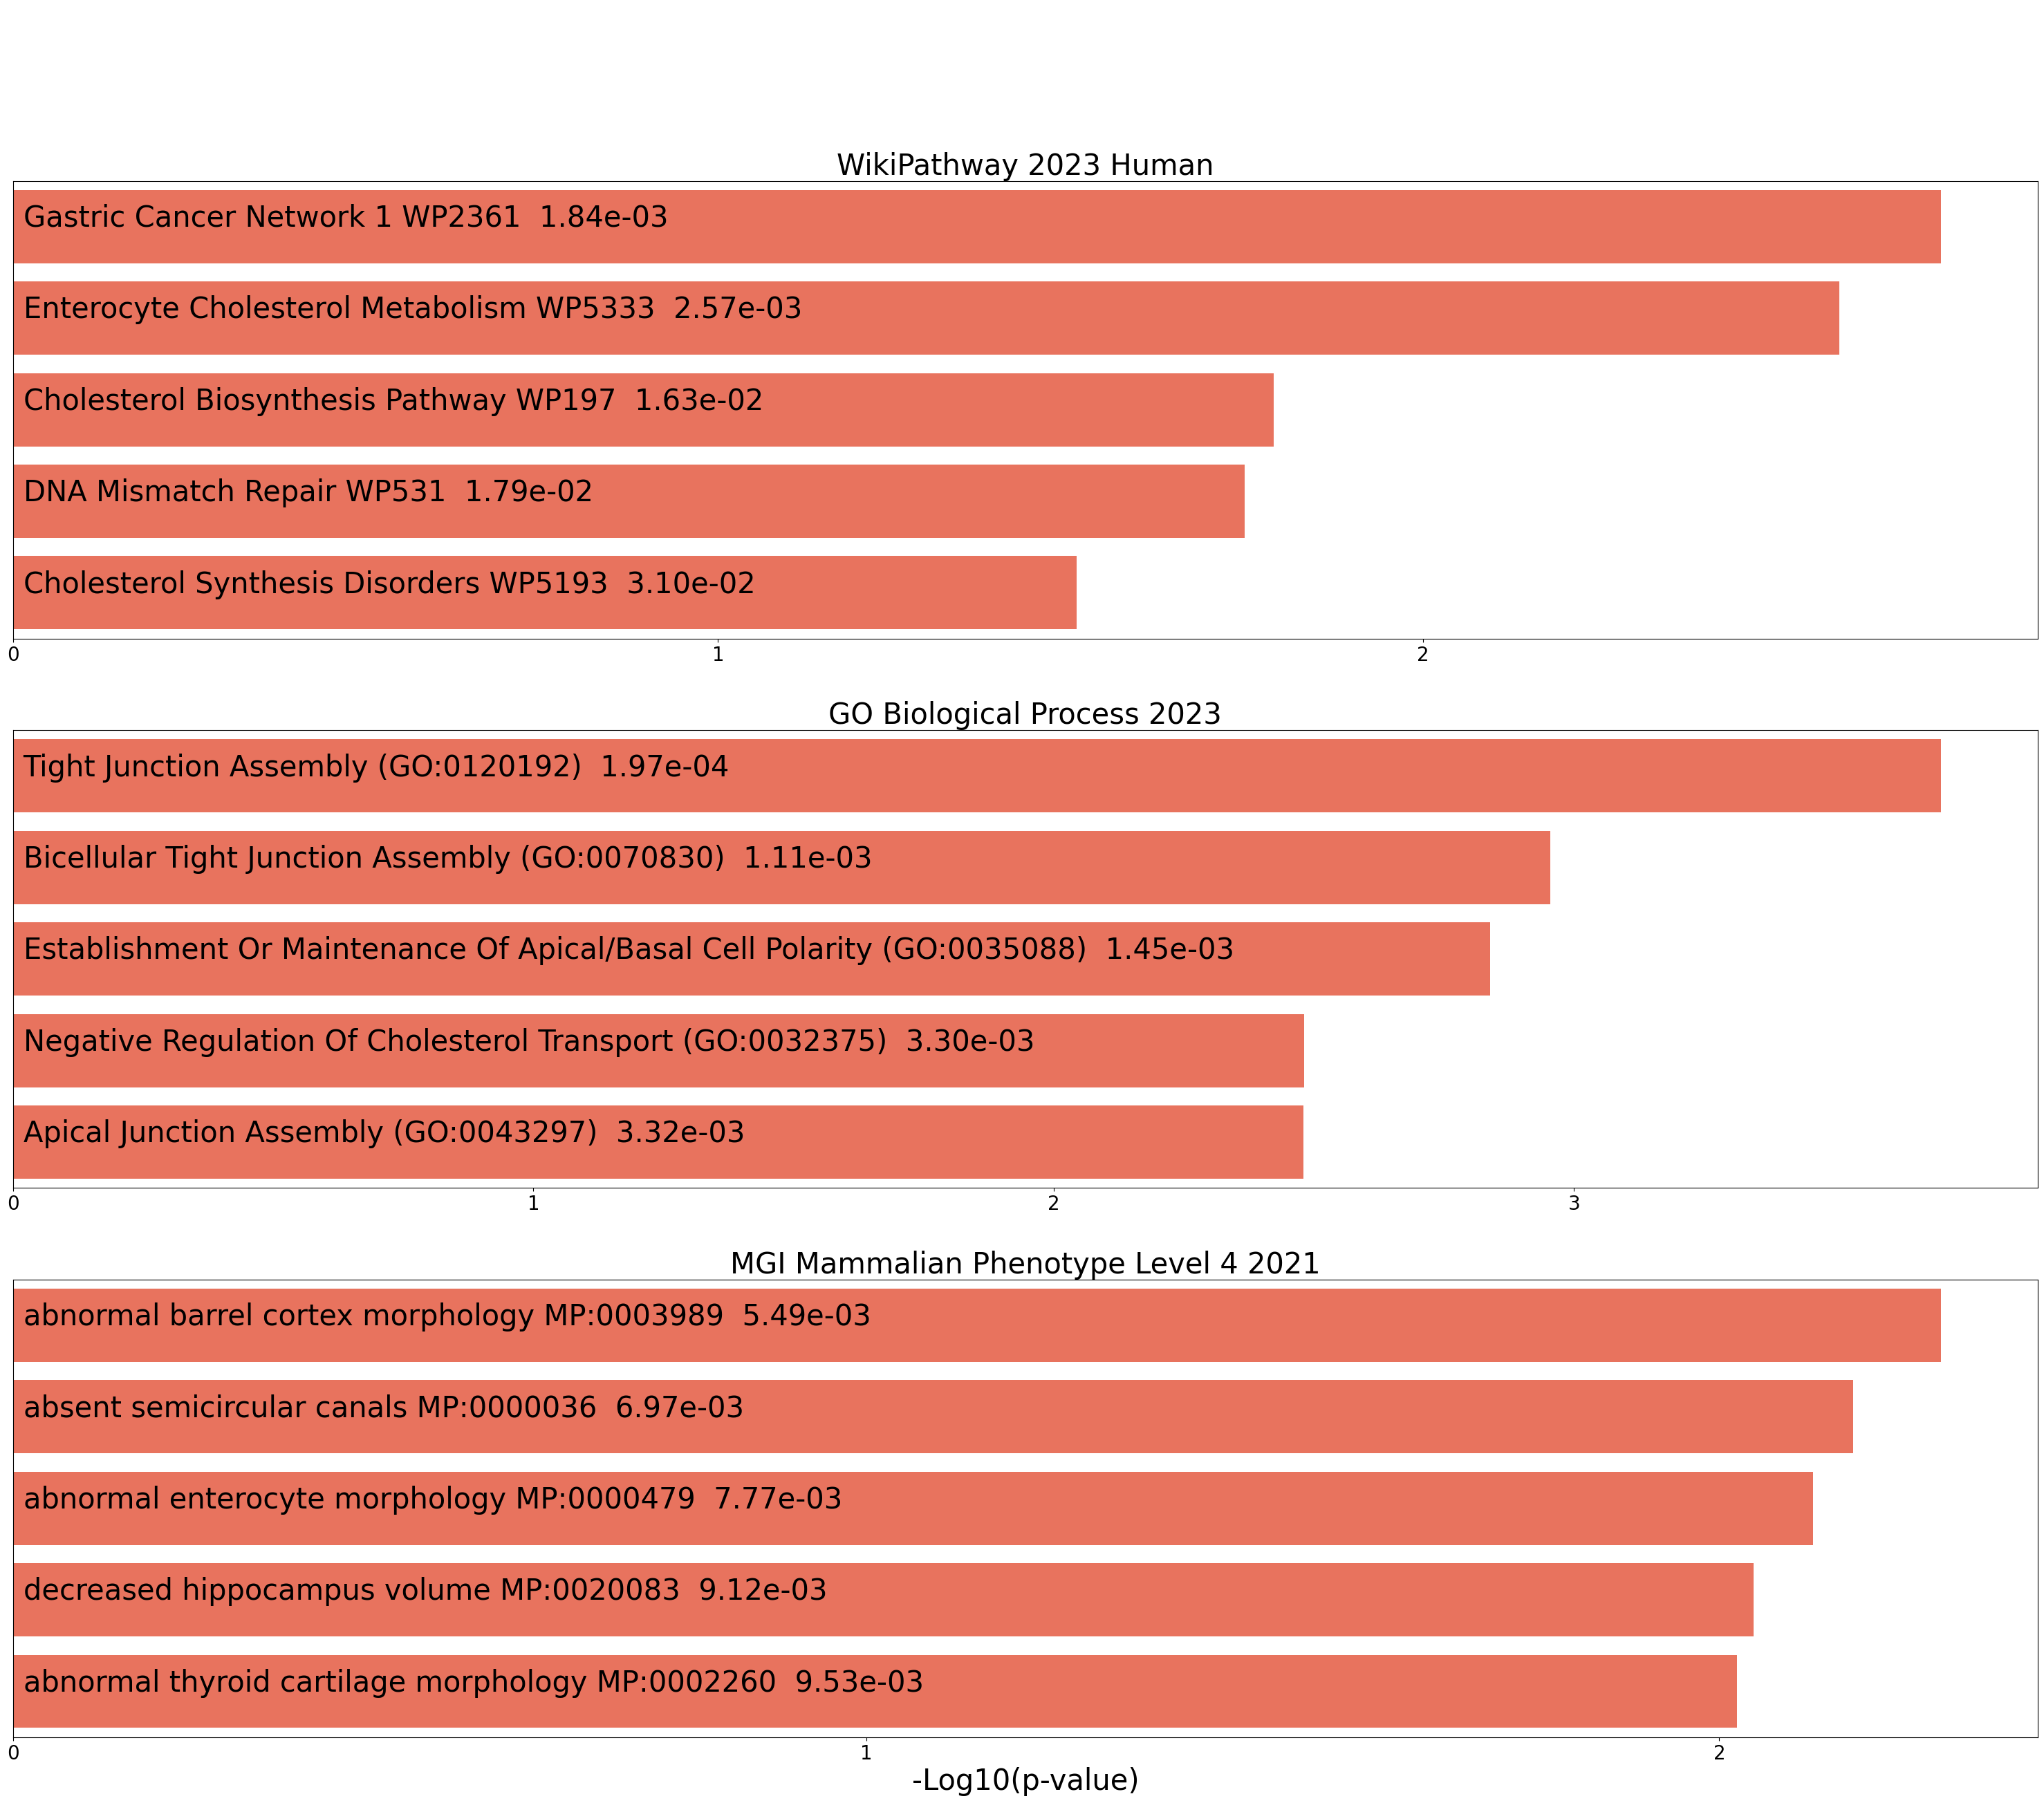

/Users/giacomomarino/X2KTR/figures/enrichr_up_cluster_2.png

/Users/giacomomarino/X2KTR/figures/enrichr_up_cluster_2.svg

#### Downregulated genes

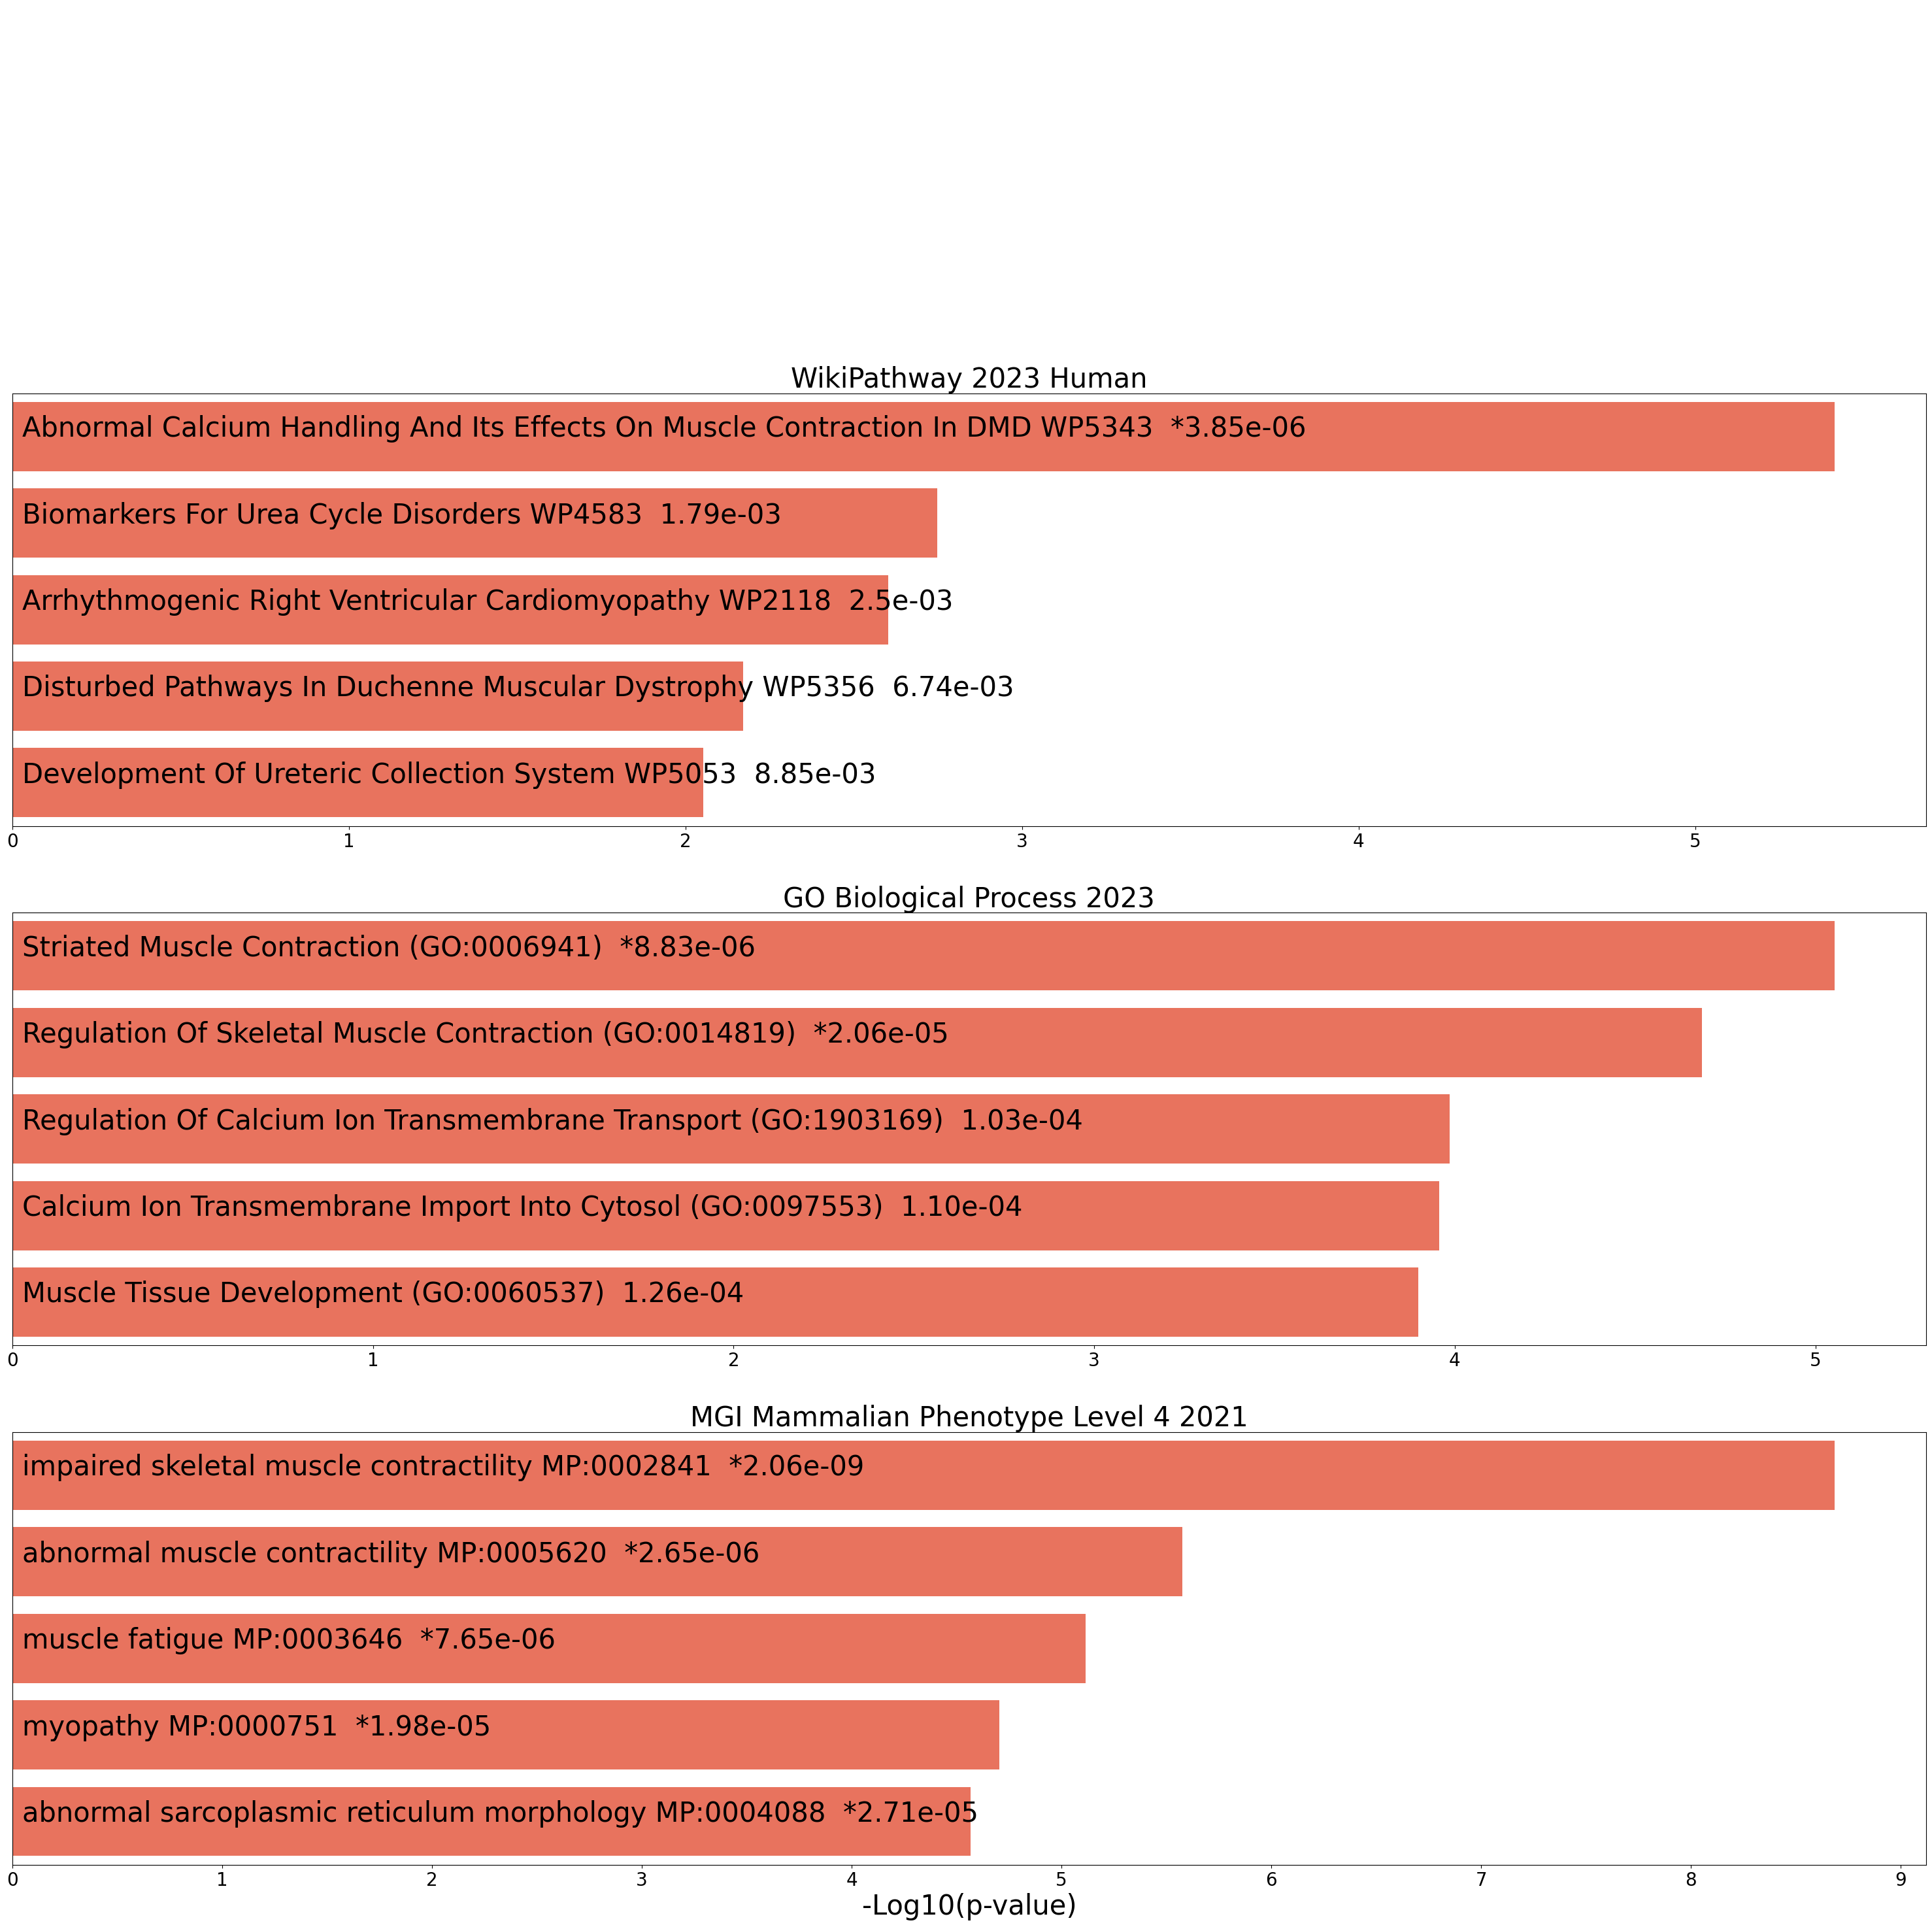

/Users/giacomomarino/X2KTR/figures/enrichr_dn_cluster_2.png

/Users/giacomomarino/X2KTR/figures/enrichr_dn_cluster_2.svg

### Cluster 3

#### Upregulated genes

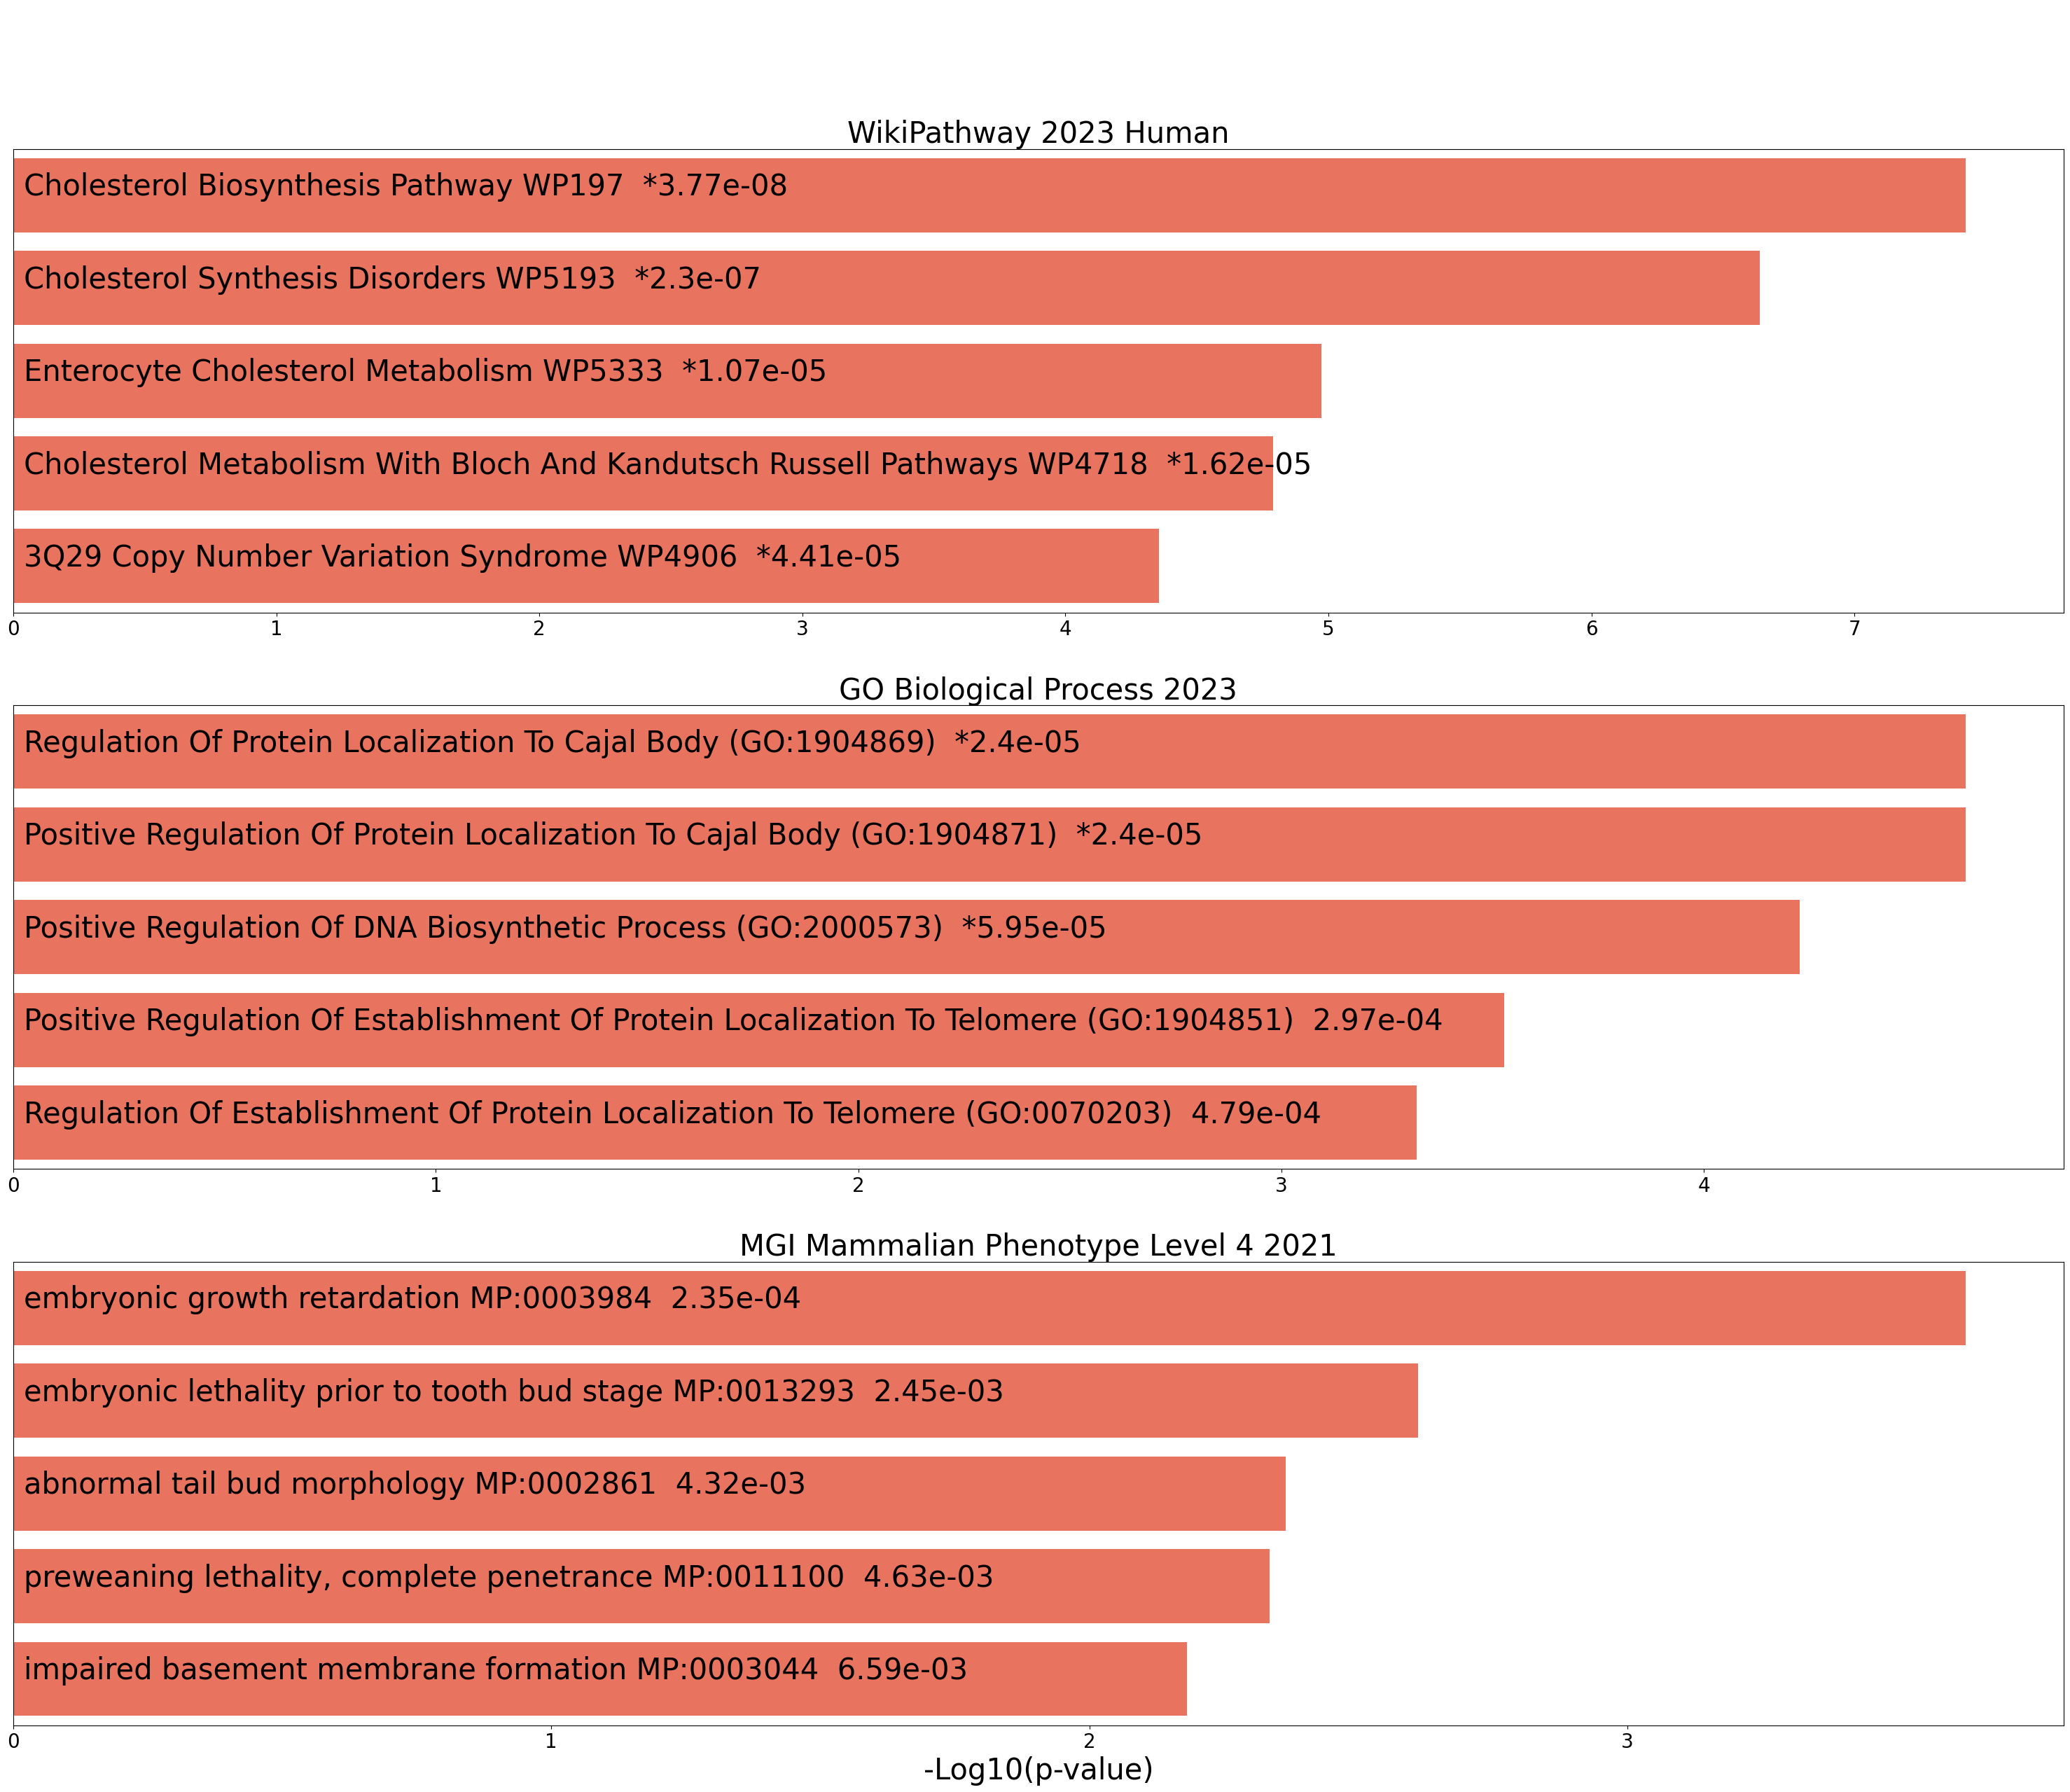

/Users/giacomomarino/X2KTR/figures/enrichr_up_cluster_3.png

/Users/giacomomarino/X2KTR/figures/enrichr_up_cluster_3.svg

#### Downregulated genes

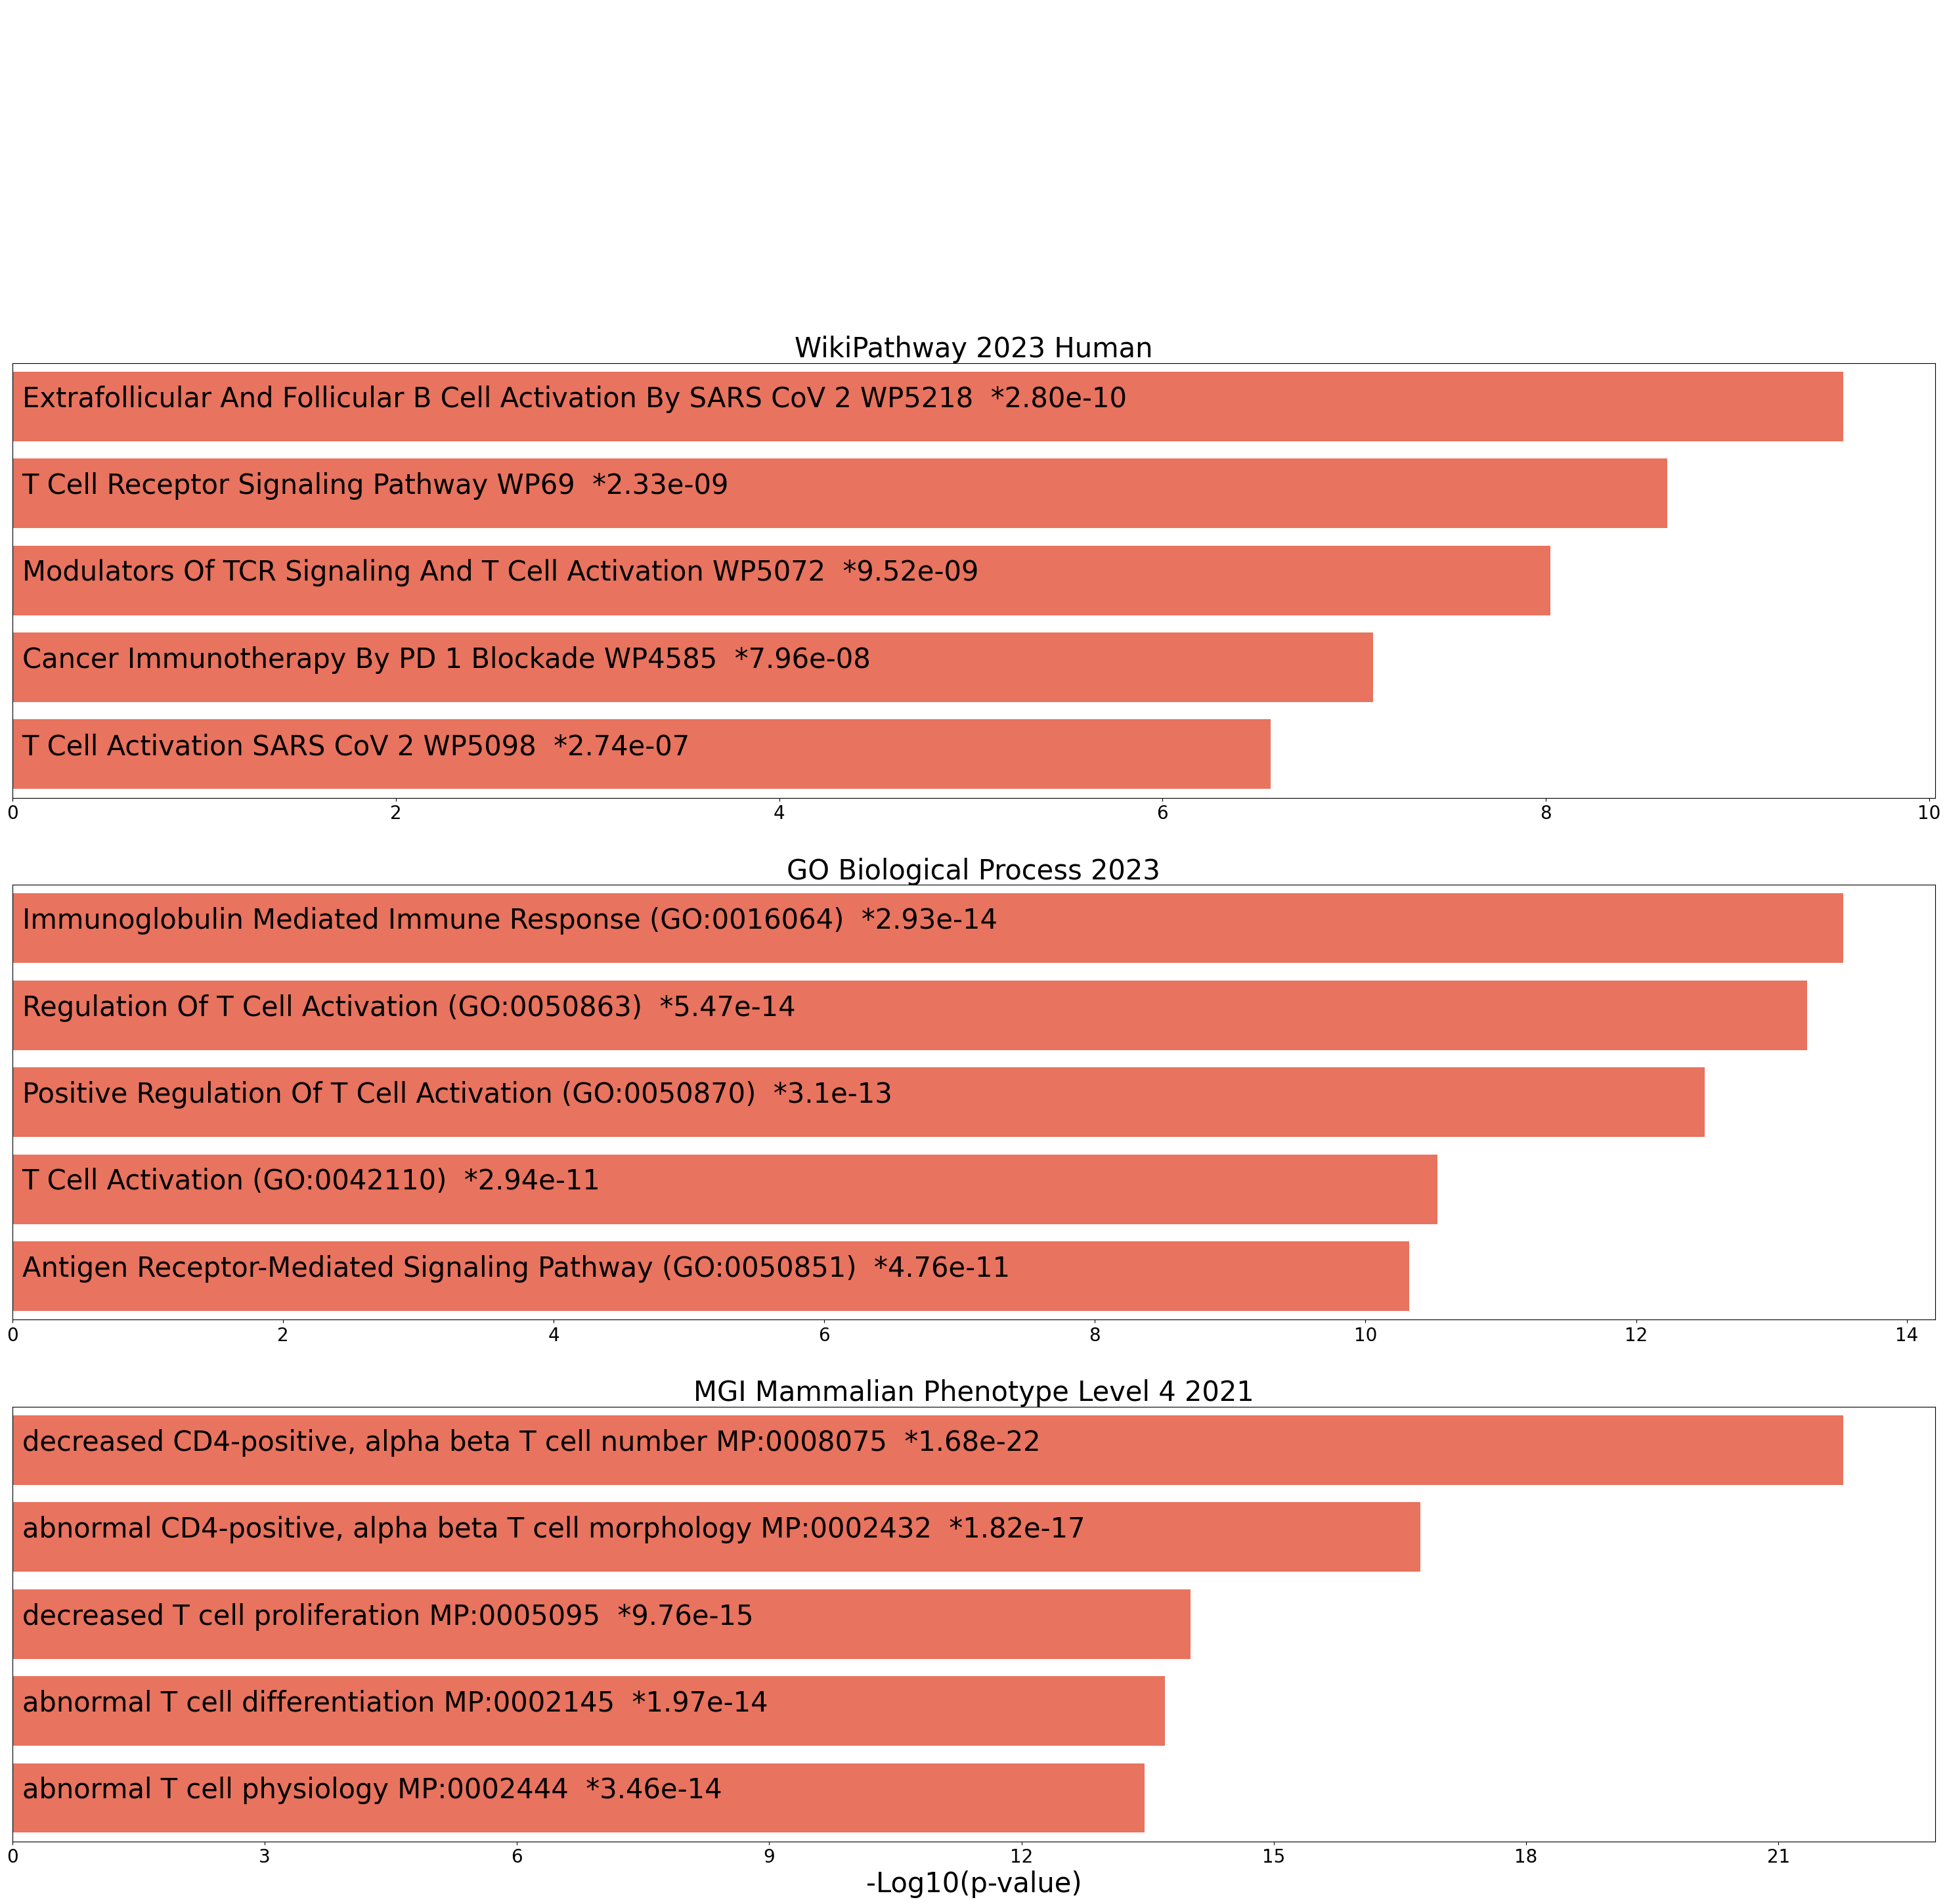

/Users/giacomomarino/X2KTR/figures/enrichr_dn_cluster_3.png

/Users/giacomomarino/X2KTR/figures/enrichr_dn_cluster_3.svg

### Cluster 4

#### Upregulated genes

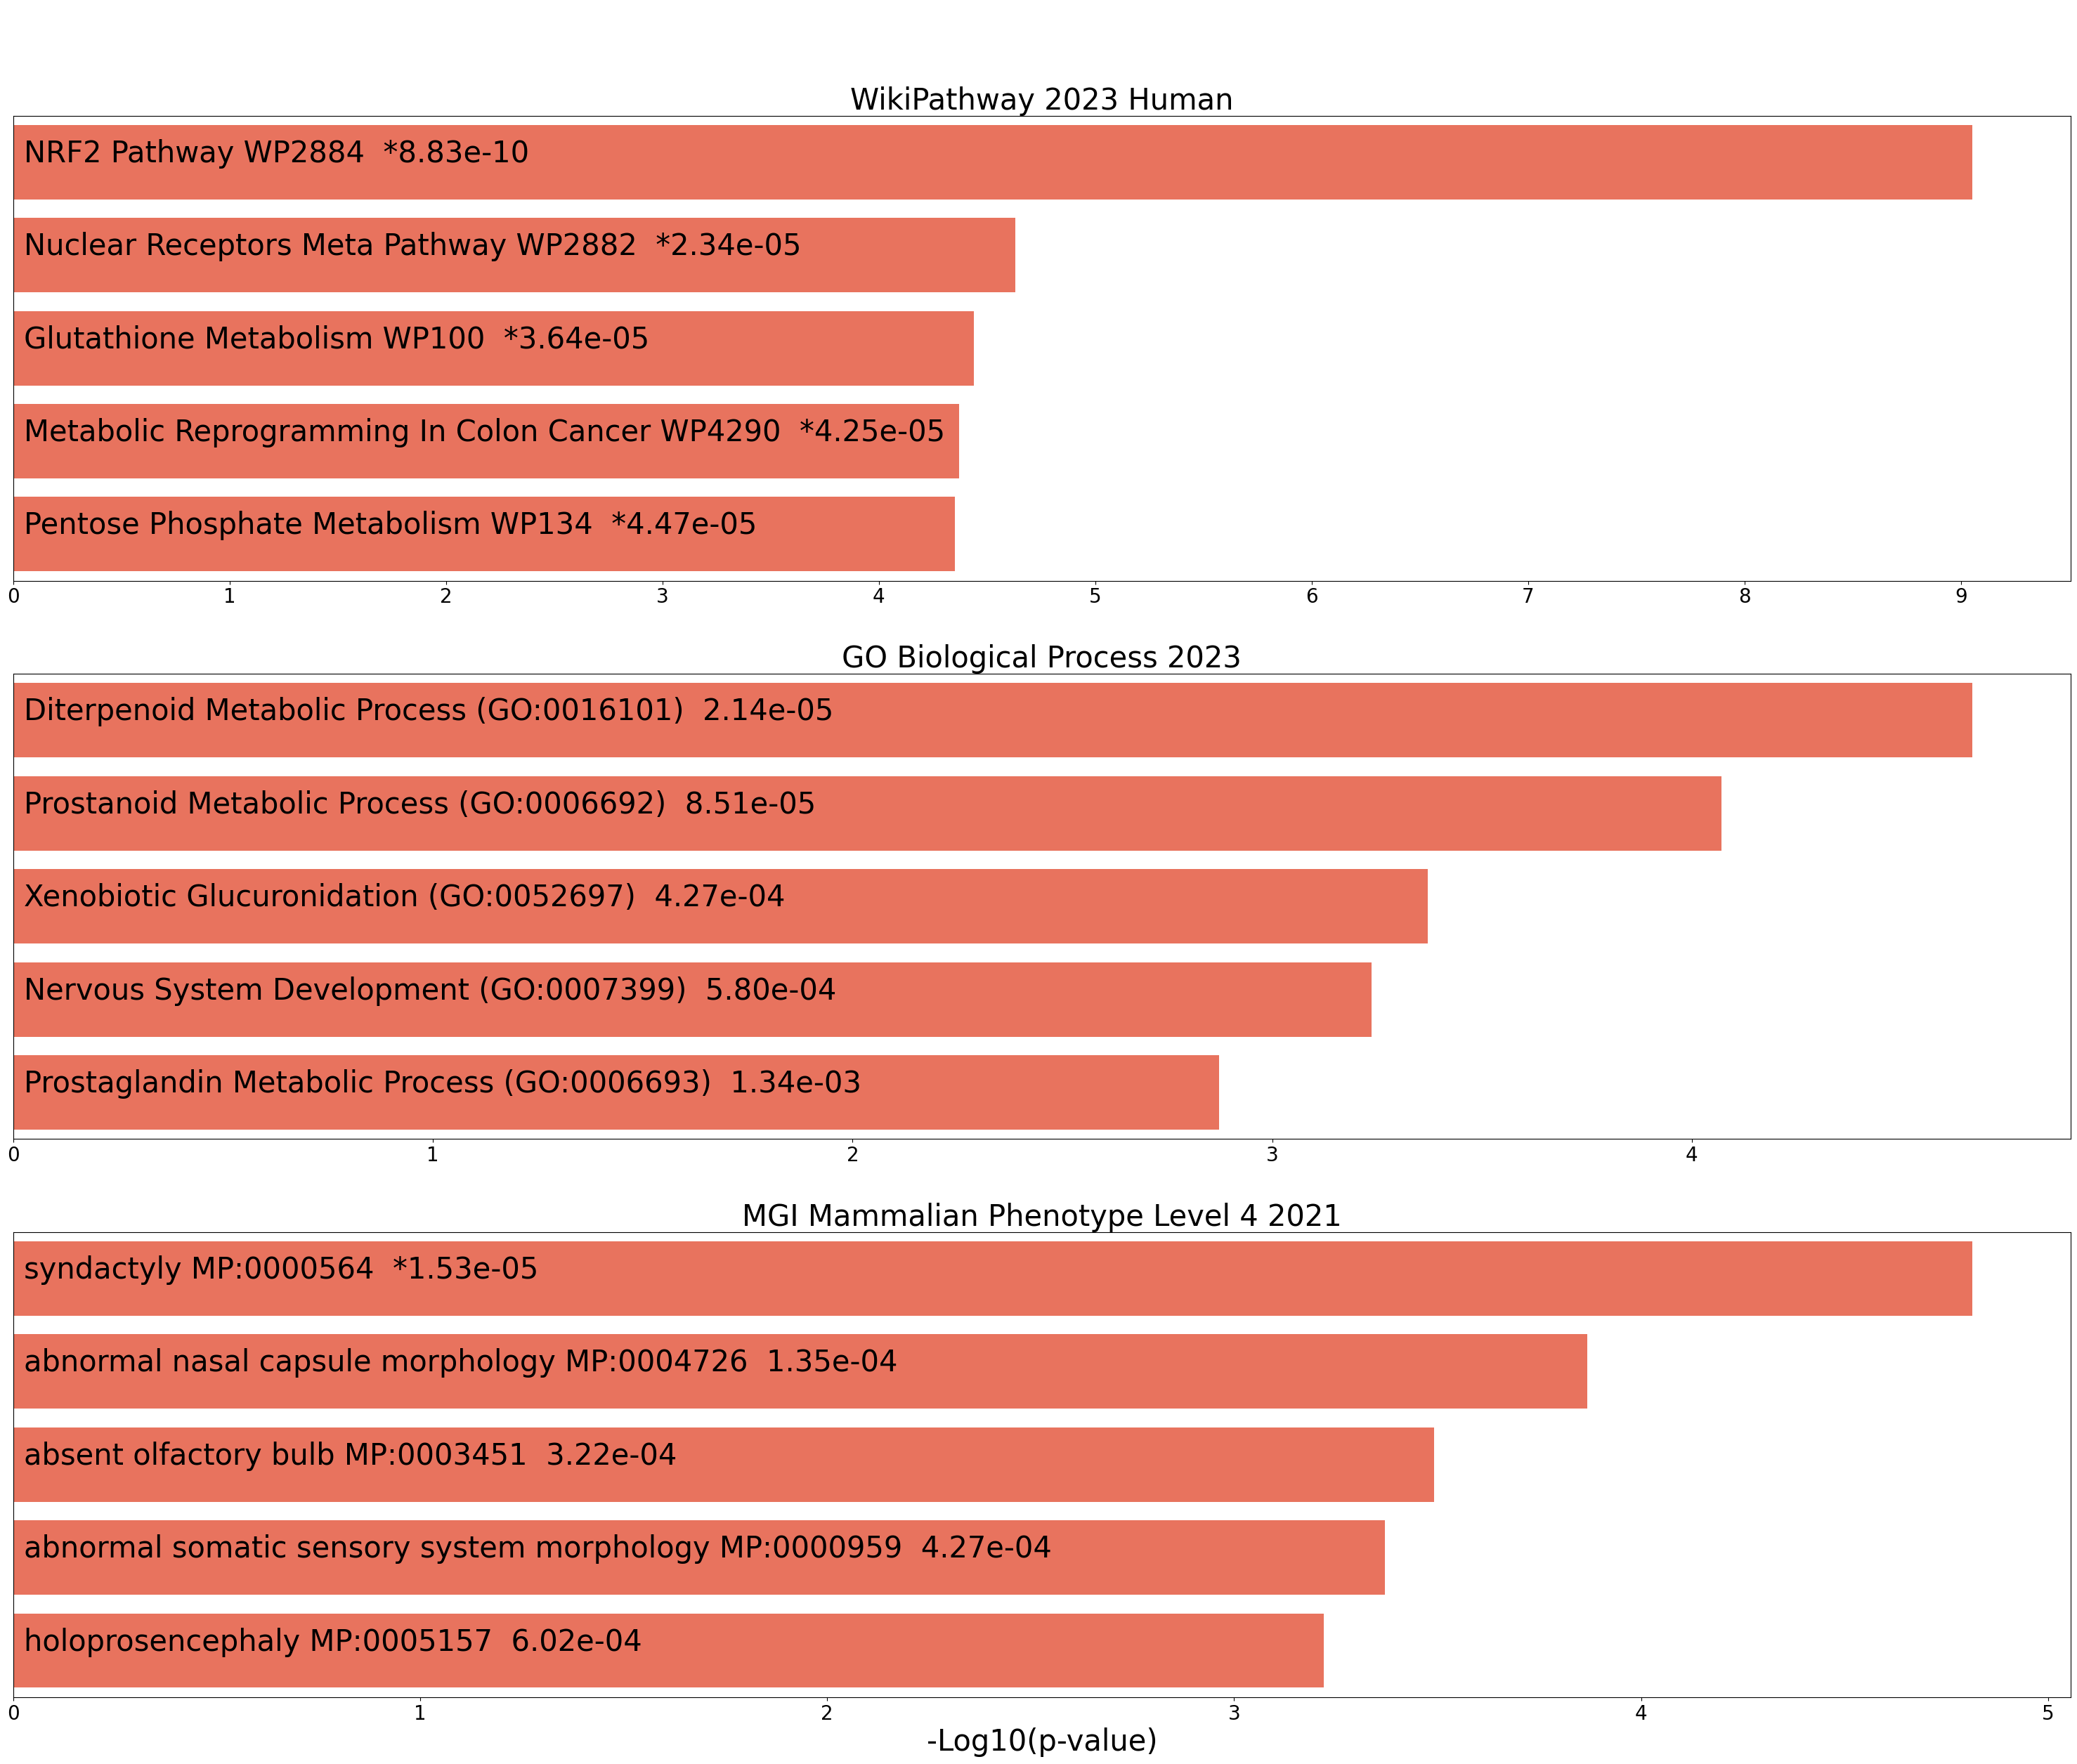

/Users/giacomomarino/X2KTR/figures/enrichr_up_cluster_4.png

/Users/giacomomarino/X2KTR/figures/enrichr_up_cluster_4.svg

#### Downregulated genes

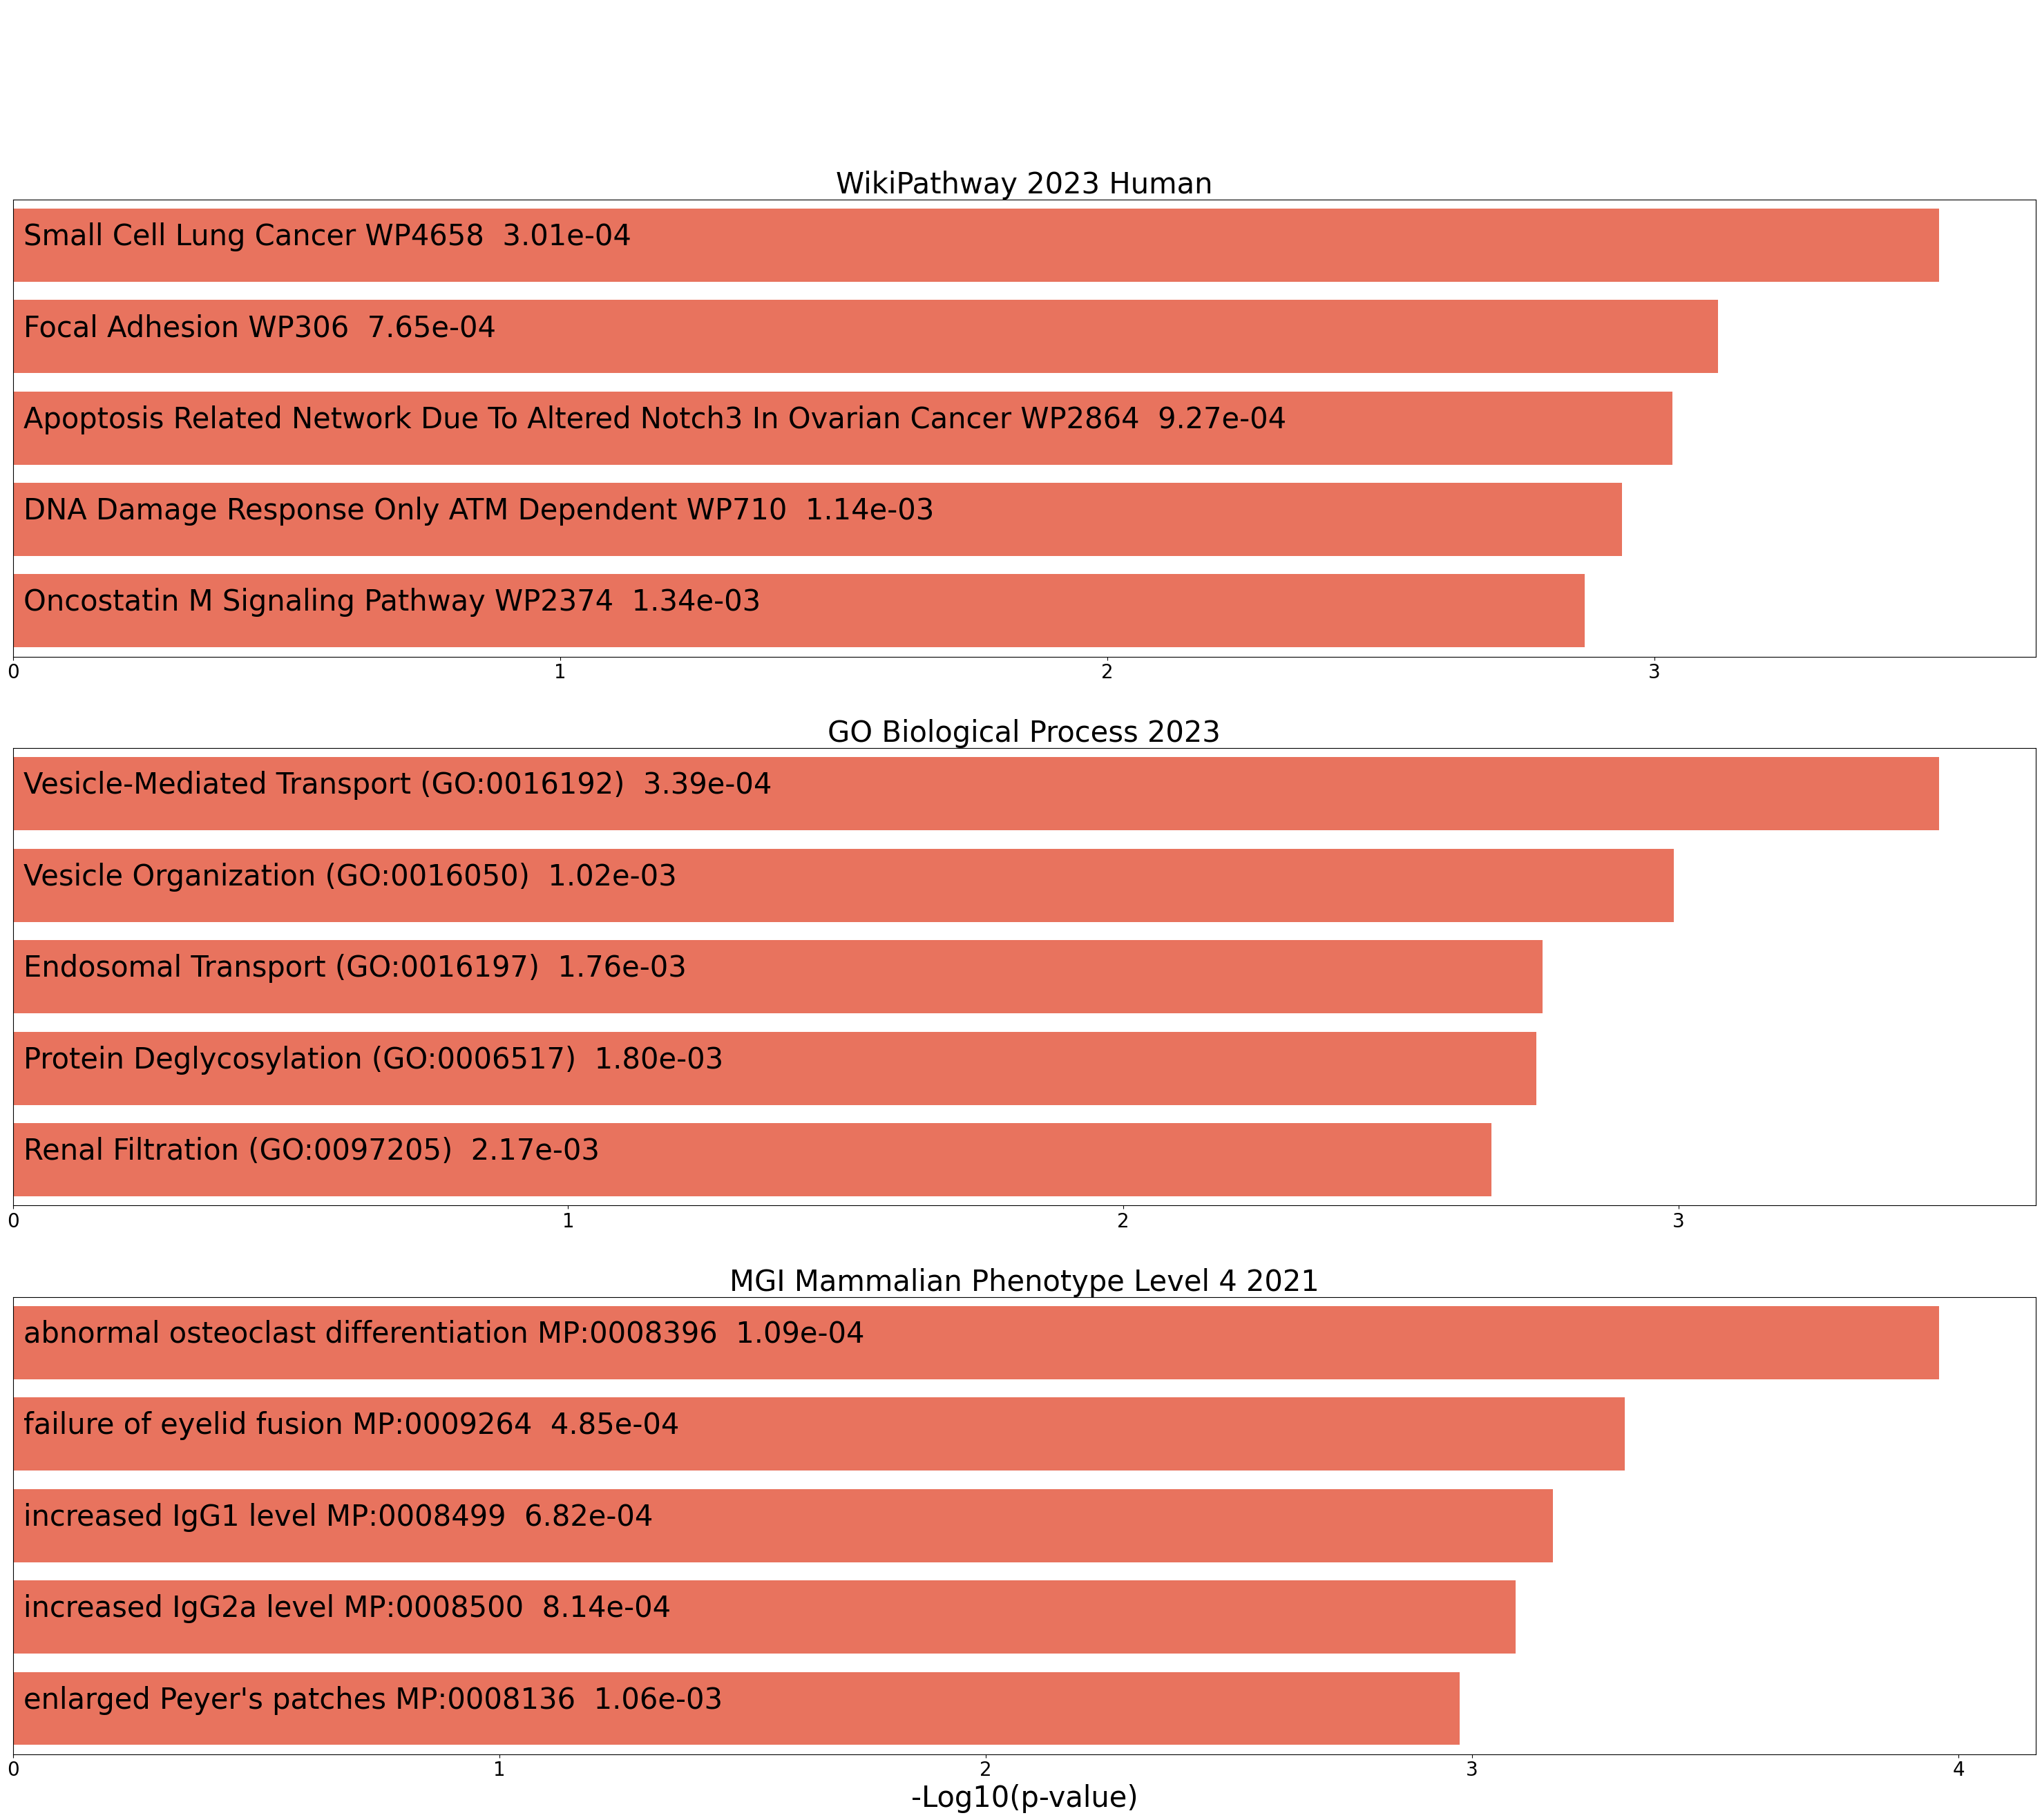

/Users/giacomomarino/X2KTR/figures/enrichr_dn_cluster_4.png

/Users/giacomomarino/X2KTR/figures/enrichr_dn_cluster_4.svg

In [144]:
for cluster in enrichr_lists:
    up, dn = enrichr_lists[cluster]
    display(Markdown(f'### Cluster {cluster}'))
    display(Markdown(f'#### Upregulated genes'))
    try:
        res_list = enrich_libraries(up['userListId'])
    except Exception as e:
        print(f'Error processing cluster {cluster} upregulated genes:', e)
    fig = enrichr_figure(res_list)
    fig.savefig(f'figures/enrichr_up_cluster_{cluster}.png', bbox_inches='tight')
    fig.savefig(f'figures/enrichr_up_cluster_{cluster}.svg', bbox_inches='tight')
    display(FileLink(f'figures/enrichr_up_cluster_{cluster}.png', result_html_prefix='Enrichr figure for upregulated genes in cluster PNG: '))
    display(FileLink(f'figures/enrichr_up_cluster_{cluster}.svg', result_html_prefix='Enrichr figure for upregulated genes in cluster SVG: '))
    display(Markdown(f'#### Downregulated genes'))
    try:
        res_list = enrich_libraries(dn['userListId'])
    except Exception as e:
        print(f'Error processing cluster {cluster} downregulated genes:', e)
    fig = enrichr_figure(res_list)
    fig.savefig(f'figures/enrichr_dn_cluster_{cluster}.png', bbox_inches='tight')
    fig.savefig(f'figures/enrichr_dn_cluster_{cluster}.svg', bbox_inches='tight')
    display(FileLink(f'figures/enrichr_dn_cluster_{cluster}.png', result_html_prefix='Enrichr figure for downregulated genes in cluster PNG: '))
    display(FileLink(f'figures/enrichr_dn_cluster_{cluster}.svg', result_html_prefix='Enrichr figure for downregulated genes in cluster SVG: '))

In [145]:
%%appyter markdown
{% if membrane_screener %}
### Load Membrane Proteins for Screening
{% if membrane_screener_list.raw_value == 'Membranome' %}
Membrane proteins are ideal targets, we can get these from [Membranome](https://membranome.org/) among other places.
{% else %}
Membrane proteins are ideal targets. This membrane/surface protein filter was created from the intersection of two data sources:
[COMPARTMENTS](https://compartments.jensenlab.org/About) knowledge predictions for human genes where a filter was applied for "Plasma membrane" and "Cell surface" subcellular localization with a confidence score greater than or equal to 3 and [Human Protein Atlas](https://www.proteinatlas.org/) membrane proteins where a filter was applied for "Evidence at protein level" and removal of genes with "Low tissue specificity."
{% endif %}
{% endif %}


### Load Membrane Proteins for Screening

Membrane proteins are ideal targets. This membrane/surface protein filter was created from the intersection of two data sources:
[COMPARTMENTS](https://compartments.jensenlab.org/About) knowledge predictions for human genes where a filter was applied for "Plasma membrane" and "Cell surface" subcellular localization with a confidence score greater than or equal to 3 and [Human Protein Atlas](https://www.proteinatlas.org/) membrane proteins where a filter was applied for "Evidence at protein level" and removal of genes with "Low tissue specificity."



In [146]:
%%appyter code_exec
{% if membrane_screener %}
proteins = pd.read_csv({{ membrane_screener_list }})
{% if membrane_screener_list.raw_value == 'Membranome' %}
proteins = proteins[proteins['species_name_cache'] == 'Homo sapiens']
{% endif %}
membrane_proteins = list(proteins['genename'].map(lookup).dropna().values)
{% endif %}

```python
proteins = pd.read_csv('https://appyters.maayanlab.cloud/storage/Tumor_Gene_Target_Screener/surfaceome.csv')
membrane_proteins = list(proteins['genename'].map(lookup).dropna().values)
```

### Cell Surface Target Identification
By comparing the inputted samples with processed RNA-seq from several atlases containing healthy expression (GTEx [2], ARCHS4 [3], and Tabula Sapiens [4]), we identify genes that are highly expressed in the target cells while lowly expressed across normal human cell types, and tissues.

In [147]:
targets = {}
bgs = {'GTEx': 'gtex-gene-stats.tsv', 'ARCHS4': 'archs4-gene-stats.tsv', 'TS': 'ts_10x_cell-ontology-class_donors_tissue-labels_v1.tsv'}
for bg in bgs:
    print('Finding Targets using', bg)
    df_bg_stats = pd.read_csv(f"https://appyters.maayanlab.cloud/storage/Tumor_Gene_Target_Screener/{bgs[bg]}", sep='\t', index_col=[0,1])
    df_bg_genes = df_bg_stats.unstack().index.map(lambda idx: lookup(idx.partition('.')[0]))
    df_bg_stats = df_bg_stats.unstack().groupby(df_bg_genes, observed=True).median().stack()
    df_bg_expr = df_bg_stats.loc[(slice(None), ['25%', '50%', '75%']), :].unstack()
    common_index = list(set(rna_df.index) & set(df_bg_expr.index))
    target_distribution = df_bg_expr.loc[common_index, :].median(axis=1)
    expr_df = rna_df.loc[common_index, :]
    expr_df.reset_index(inplace=True)
    expr_df.drop_duplicates(subset='gene_id', inplace=True)
    expr_df.set_index('gene_id', inplace=True, drop=True)
    df_expr_norm = qnorm.quantile_normalize(expr_df.loc[common_index, :], target=target_distribution)
    df_bg_expr_norm = qnorm.quantile_normalize(df_bg_expr.loc[common_index, :], target=target_distribution)
    for cluster in tqdm(clusters):
        if cluster not in targets: targets[cluster] = {}
        cluster_samples = list(leiden_df[leiden_df['leiden'] == cluster].index.values)
        with suppress_output():
            df_bg_expr_norm.columns = df_bg_expr_norm.columns.to_flat_index().map(lambda s: ', '.join(s))
            dge = limma_voom_differential_expression(
                df_bg_expr_norm, df_expr_norm[cluster_samples],
                voom_design=True,
            )
            targets[cluster][bg] = dge[(dge['adj.P.Val'] < 0.01) & (dge['t'] > 0)].sort_values('t', ascending=False).index.values 

Finding Targets using GTEx


100%|██████████| 5/5 [00:35<00:00,  7.08s/it]


Finding Targets using ARCHS4


100%|██████████| 5/5 [03:02<00:00, 36.54s/it]


Finding Targets using TS


100%|██████████| 5/5 [03:39<00:00, 43.92s/it]


```python
YlGnBu = cm.get_cmap('YlGnBu_r', 8)
cmap = {"None":YlGnBu(0), "ARCHS4": YlGnBu(1), "GTEx":YlGnBu(2), "TS": YlGnBu(4), "ARCHS4-GTEx":YlGnBu(3),  "ARCHS4-TS": YlGnBu(5), "GTEx-TS": YlGnBu(6), "All": YlGnBu(7)}
top_targets_n = 100
target_list = []
for cluster in targets:
    for bg in targets[cluster]:
        target_list.extend(list(filter(lambda g: g in membrane_proteins, targets[cluster][bg][:top_targets_n])))
data1, data2, data3 = [], [], []
similarity = []
target_list = list(set(target_list))
for gene in target_list:
    a = [1 if gene in targets[c]['ARCHS4'][:top_targets_n] else 0 for c in clusters]
    g = [2 if gene in targets[c]['GTEx'][:top_targets_n] else 0 for c in clusters]
    l = [4 if gene in targets[c]['TS'][:top_targets_n] else 0 for c in clusters]
    data1.append(a)
    data2.append(g)
    data3.append(l)
    similarity.append(np.dot(np.dot(np.array(a), np.array(g)), np.array(l)))
data = np.add(np.add(data1, data2), data3)
membrane_target_mat = pd.DataFrame(data)
membrane_target_mat.columns = [f"Cluster {c}" for c in clusters]
membrane_target_mat.index = target_list
membrane_target_mat['count'] = membrane_target_mat.sum(axis=1)
membrane_target_mat = membrane_target_mat[membrane_target_mat['count'] >= 7]
membrane_target_mat = membrane_target_mat.rename_axis('Membrane Target').sort_values(by = ['count', 'Membrane Target'], ascending = [False, True]).drop('count', axis=1)
h = membrane_target_mat.shape[0]
g = sns.clustermap(membrane_target_mat, figsize=(4,0.3*h+2*(h<15)), cmap=YlGnBu, cbar_pos=None, dendrogram_ratio=0.1-(h<40)*0.01*(h-30), row_cluster=False, xticklabels=True, yticklabels=True, standard_scale=1)
g.ax_row_dendrogram.legend(handles=[Rectangle((0, 0), 0, 0, color=val, label=key) for key, val in cmap.items()],
                                title='Background', loc='upper right')
plt.show()
g.savefig(f'figures/{rna_filename}_membrane_target_matrix.png', dpi=300, bbox_inches='tight')
g.savefig(f'figures/{rna_filename}_membrane_target_matrix.svg', dpi=300, bbox_inches='tight')
membrane_target_mat.to_csv(f'results/{rna_filename}_membrane_target_mat.csv')
display(FileLink(f'results/{rna_filename}_membrane_target_mat.csv', result_html_prefix='Download Membrane Target Matrix: '))
display(FileLink(f'figures/{rna_filename}_membrane_target_matrix.png', result_html_prefix='Membrane Target Matrix PNG: '))
display(FileLink(f'figures/{rna_filename}_membrane_target_matrix.svg', result_html_prefix='Membrane Target Matrix SVG: '))
```

<string>:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


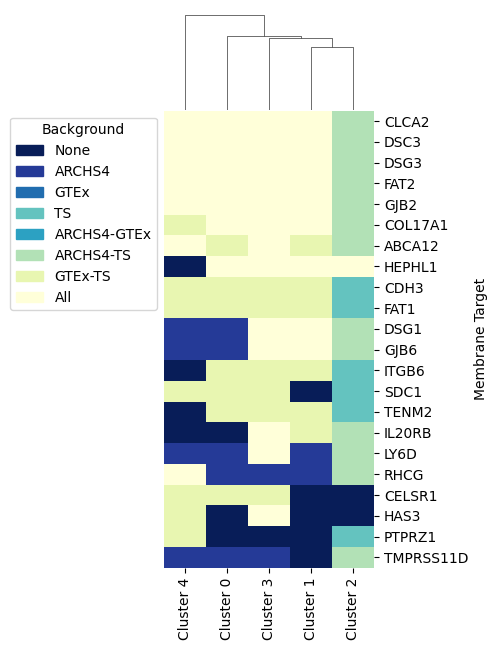

/Users/giacomomarino/X2KTR/results/CPTAC3_HNSCC_tumor_counts_membrane_target_mat.csv

/Users/giacomomarino/X2KTR/figures/CPTAC3_HNSCC_tumor_counts_membrane_target_matrix.png

/Users/giacomomarino/X2KTR/figures/CPTAC3_HNSCC_tumor_counts_membrane_target_matrix.svg

In [148]:
%%appyter code_exec
YlGnBu = cm.get_cmap('YlGnBu_r', 8)
cmap = {"None":YlGnBu(0), "ARCHS4": YlGnBu(1), "GTEx":YlGnBu(2), "TS": YlGnBu(4), "ARCHS4-GTEx":YlGnBu(3),  "ARCHS4-TS": YlGnBu(5), "GTEx-TS": YlGnBu(6), "All": YlGnBu(7)}

top_targets_n = 100
target_list = []
for cluster in targets:
    for bg in targets[cluster]:
        target_list.extend(list(filter(lambda g: g in membrane_proteins, targets[cluster][bg][:top_targets_n])))
data1, data2, data3 = [], [], []
similarity = []
target_list = list(set(target_list))

for gene in target_list:
    a = [1 if gene in targets[c]['ARCHS4'][:top_targets_n] else 0 for c in clusters]
    g = [2 if gene in targets[c]['GTEx'][:top_targets_n] else 0 for c in clusters]
    l = [4 if gene in targets[c]['TS'][:top_targets_n] else 0 for c in clusters]
    data1.append(a)
    data2.append(g)
    data3.append(l)
    similarity.append(np.dot(np.dot(np.array(a), np.array(g)), np.array(l)))

data = np.add(np.add(data1, data2), data3)

membrane_target_mat = pd.DataFrame(data)
membrane_target_mat.columns = [f"Cluster {c}" for c in clusters]
membrane_target_mat.index = target_list

membrane_target_mat['count'] = membrane_target_mat.sum(axis=1)
membrane_target_mat = membrane_target_mat[membrane_target_mat['count'] >= 7]
membrane_target_mat = membrane_target_mat.rename_axis('Membrane Target').sort_values(by = ['count', 'Membrane Target'], ascending = [False, True]).drop('count', axis=1)

h = membrane_target_mat.shape[0]



g = sns.clustermap(membrane_target_mat, figsize=(4,0.3*h+2*(h<15)), cmap=YlGnBu, cbar_pos=None, dendrogram_ratio=0.1-(h<40)*0.01*(h-30), row_cluster=False, xticklabels=True, yticklabels=True, standard_scale=1)
g.ax_row_dendrogram.legend(handles=[Rectangle((0, 0), 0, 0, color=val, label=key) for key, val in cmap.items()],
                                title='Background', loc='upper right')

plt.show()

g.savefig(f'figures/{rna_filename}_membrane_target_matrix.png', dpi=300, bbox_inches='tight')
g.savefig(f'figures/{rna_filename}_membrane_target_matrix.svg', dpi=300, bbox_inches='tight')
membrane_target_mat.to_csv(f'results/{rna_filename}_membrane_target_mat.csv')

display(FileLink(f'results/{rna_filename}_membrane_target_mat.csv', result_html_prefix='Download Membrane Target Matrix: '))
display(FileLink(f'figures/{rna_filename}_membrane_target_matrix.png', result_html_prefix='Membrane Target Matrix PNG: '))
display(FileLink(f'figures/{rna_filename}_membrane_target_matrix.svg', result_html_prefix='Membrane Target Matrix SVG: '))

In [ ]:
rna_df_log2_zscore = zscore(log2_normalize(rna_df), axis=0)
rna_df_log2_zscore

In [ ]:
chea_res = {}
for patient in tqdm(rna_df_log2_zscore.columns.values):
    chea_res[patient] = {}
    down_rows = rna_df_log2_zscore[patient].astype(float).sort_values(ascending=True)[:500]
    up_rows = rna_df_log2_zscore[patient].astype(float).sort_values(ascending=False)[:500]

    down_genes = list(set(down_rows.index.map(lambda g: lookup(g.split('.')[0]) if lookup(g.split('.')[0]) else g.split('.')[0])))
    up_genes = list(set(up_rows.index.map(lambda g: lookup(g.split('.')[0]) if lookup(g.split('.')[0]) else g.split('.')[0])))

    chea_down = get_chea3_results(down_genes, f'{patient}_down_genes')
    chea_up = get_chea3_results(up_genes, f'{patient}_up_genes')
    chea_res[patient]['down'] = chea_down
    chea_res[patient]['up'] = chea_up

In [ ]:
ids = list(chea_res.keys())

n_TFs = 20

up_TFs = {}
up_intermediates = {}
with tqdm(total=len(ids)) as pbar:
    pbar.set_description("Augmenting TFs from up-genes...")
    for id in ids:
        up_TFs[id] = chea_res[id]['up'].astype(float).sort_values(by='Score', ascending=True).index[:n_TFs].to_list()
        up_intermediates[id] = geneshot_set_augment(gene_list=up_TFs[id])
        pbar.update(1)
up_TFs = pd.DataFrame(up_TFs)
up_intermediates = pd.DataFrame(up_intermediates)
up_TFs.to_csv(f"results/up_TFs.csv", index=False)
up_intermediates.to_csv(f"results/up_intermediates.csv", index=False)

dn_TFs = {}
dn_intermediates = {}
with tqdm(total=len(ids)) as pbar:
    pbar.set_description("Augmenting TFs from down-genes...")
    for id in ids:
        dn_TFs[id] = chea_res[id]['down'].astype(float).sort_values(by='Score', ascending=True).index[:n_TFs].to_list()
        dn_intermediates[id] = geneshot_set_augment(gene_list=dn_TFs[id])
        pbar.update(1)
dn_TFs = pd.DataFrame(dn_TFs)
dn_intermediates = pd.DataFrame(dn_intermediates)
dn_TFs.to_csv(f"results/dn_TFs.csv", index=False)
dn_intermediates.to_csv(f"results/dn_intermediates.csv", index=False)

In [ ]:
# Compute normalized kinase enrichment scores
up_kinases = {}
dn_kinases = {}
x2k_up = {}
x2k_dn = {}

with tqdm(total=len(ids)) as pbar:
    pbar.set_description("Computing RNA-seq derived KEA scores...")
    for id in ids:
        up_geneset = list(set(list(up_TFs[id]) + list(up_intermediates[id])))
        dn_geneset = list(set(list(dn_TFs[id]) + list(dn_intermediates[id])))
        up_results = get_kea3_results(up_geneset)
        dn_results = get_kea3_results(dn_geneset)
        up_kinases[id] = up_results.astype(float).sort_values(by="Score", ascending=True).index.to_list()
        dn_kinases[id] = dn_results.astype(float).sort_values(by="Score", ascending=True).index.to_list()
        if len(x2k_up) == 0:
            KINASES = up_results.Score.index.to_list()
        x2k_up[id] = up_results.Score.loc[KINASES]
        x2k_dn[id] = dn_results.Score.loc[KINASES]
        pbar.update(1)

pd.DataFrame(up_kinases).to_csv(f"results/up_kinases.csv", index=False)
pd.DataFrame(dn_kinases).to_csv(f"results/dn_kinases.csv", index=False)
x2k_up = pd.DataFrame(x2k_up, index=KINASES)
x2k_dn = pd.DataFrame(x2k_dn, index=KINASES)
x2k_up.to_csv(f"results/up_x2k_zscores.csv")
x2k_dn.to_csv(f"results/dn_x2k_zscores.csv")

In [ ]:
reds_reversed = cm.get_cmap('Reds').reversed()
g = sns.clustermap(x2k_up.astype(float), cmap=reds_reversed, center=0, xticklabels=False, yticklabels=False)

In [ ]:
g = sns.clustermap(x2k_dn.astype(float), cmap=reds_reversed, center=0, xticklabels=False, yticklabels=False)

# Phosphoproteomics

In [ ]:
percentages = []
idx = []
i = 0
for _, row in tqdm(phospho_df.iterrows(), total=len(phospho_df)):
    value_counts = row.astype(float).isna().value_counts()
    pr = value_counts[0]/len(row)
    if pr > 0.8:
        idx.append(i)
    percentages.append(pr)
    i += 1
ax = pd.Series(percentages).hist()
ax.set_ylabel("# Phosphosites")
ax.set_xlabel("% with values")

In [ ]:
phospho_df_imputed = phospho_df.iloc[idx].T.fillna(phospho_df.iloc[idx].mean(axis=1)).T.astype(float)
zscored_phospho = zscore(phospho_df_imputed.astype(float), axis=0, nan_policy='omit')
zscored_phospho.head(10)

In [ ]:
zscored_phospho_var = zscored_phospho.var(axis=1).sort_values(ascending=False)
zscored_phospho_var_list = zscored_phospho_var.index[:100].tolist()
zscored_phospho_var.head(10)

In [ ]:
g = sns.clustermap(zscored_phospho.loc[zscored_phospho_var_list], cmap='coolwarm', center=0, xticklabels=False, yticklabels=False)
ax = g.ax_heatmap
ax.set_ylabel('Top 100 Phosphosites by Variance')
ax.set_xlabel('Samples')
g.savefig(f'figures/{phospho_filename}_top_var_phosphosites_heatmap.png', dpi=300, bbox_inches='tight')
g.savefig(f'figures/{phospho_filename}_top_var_phosphosites_heatmap.svg', dpi=300, bbox_inches='tight')
display(FileLink(f'figures/{phospho_filename}_top_var_phosphosites_heatmap.png', result_html_prefix='Most Variable Phosphosites Heatmap PNG: '))
display(FileLink(f'figures/{phospho_filename}_top_var_phosphosites_heatmap.svg', result_html_prefix='Most Variable Phosphosites Heatmap SVG: '))

In [ ]:
kea_res = {}
for patient in tqdm(zscored_phospho.columns):
    kea_res[patient] = {}
    down_rows = zscored_phospho[patient].astype(float).sort_values(ascending=True)[:500]
    up_rows = zscored_phospho[patient].astype(float).sort_values(ascending=False)[:500]
    
    down_phopshosites = list(set(down_rows.index.map(lambda g: lookup(g.split('.')[0]) if lookup(g.split('.')[0]) else g.split('.')[0])))
    up_phopshosites = list(set(up_rows.index.map(lambda g: lookup(g.split('.')[0]) if lookup(g.split('.')[0]) else g.split('.')[0])))

    up_kinases = get_kea3_results(up_phopshosites, f'{patient}_up_phosphosites')
    down_kinases = get_kea3_results(down_phopshosites, f'{patient}_down_phosphosites')
    kea_res[patient]['up'] = up_kinases
    kea_res[patient]['down'] = down_kinases

## Transcriptomics + Phosphoproteomics
### Kinases enriched in both X2K and phospho- pipelines

In [ ]:

rank_threshold = 30

rec_kinases = {}
for id  in kea_res:
    up = x2k_up[id].astype(float).sort_values(ascending=True).index.to_list()
    up_phospho = kea_res[id]['up'].astype(float).sort_values(by='Score', ascending=True).index.to_list()
    rec_kinases[id] = list(set(up[:rank_threshold]) & set(up_phospho[:rank_threshold]))
up_up_df = pd.DataFrame.from_dict(rec_kinases, orient='index').T
up_up_df.to_csv(f"results/recovered_up_phospho_up_genes.csv", index=False)

rec_kinases = {}
for id  in kea_res:
    dn = x2k_dn[id].astype(float).sort_values(ascending=True).index.to_list()
    dn_phospho = kea_res[id]['down'].astype(float).sort_values(by='Score', ascending=True).index.to_list()
    rec_kinases[id] = list(set(dn[:rank_threshold]) & set(dn_phospho[:rank_threshold]))
dn_dn_df = pd.DataFrame.from_dict(rec_kinases, orient='index').T
dn_dn_df.to_csv(f"results/recovered_dn_phospho_dn_genes.csv", index=False)

rec_kinases = {}
for id in kea_res:
    dn = x2k_dn[id].astype(float).sort_values(ascending=True).index.to_list()
    up_phospho = kea_res[id]['up'].astype(float).sort_values(by='Score', ascending=True).index.to_list()
    rec_kinases[id] = list(set(dn[:rank_threshold]) & set(up_phospho[:rank_threshold]))
up_dn_df = pd.DataFrame.from_dict(rec_kinases, orient='index').T
up_dn_df.to_csv(f"results/recovered_up_phospho_dn_genes.csv", index=False)

rec_kinases = {}
for id in kea_res:
    up = x2k_up[id].astype(float).sort_values(ascending=True).index.to_list()
    dn_phospho = kea_res[id]['down'].astype(float).sort_values(by='Score', ascending=True).index.to_list()
    rec_kinases[id] = list(set(up[:rank_threshold]) & set(dn_phospho[:rank_threshold]))
dn_up_df = pd.DataFrame.from_dict(rec_kinases, orient='index').T
dn_up_df.to_csv(f"results/recovered_dn_phospho_up_genes.csv", index=False)

In [ ]:
display(up_up_df.head())
display(FileLink(f"results/recovered_up_phospho_up_genes.csv", result_html_prefix='Download Recovered Kinases (up-up):'))

In [ ]:
display(dn_dn_df.head())
display(FileLink(f"results/recovered_dn_phospho_dn_genes.csv", result_html_prefix='Download Recovered Kinases (down-down):'))

In [ ]:
display(up_dn_df.head())
display(FileLink(f"results/recovered_up_phospho_dn_genes.csv", result_html_prefix='Download Recovered Kinases (up-down):'))

In [ ]:
display(dn_up_df.head())
display(FileLink(f"results/recovered_dn_phospho_up_genes.csv", result_html_prefix='Download Recovered Kinases (down-up):'))

# Proteomics

In [ ]:
percentages = []
idx = []
i = 0
for _, row in tqdm(prot_df.iterrows(), total=len(prot_df)):
    value_counts = row.astype(float).isna().value_counts()
    pr = value_counts[0]/len(row)
    if pr > 0.8:
        idx.append(i)
    percentages.append(pr)
    i += 1
ax = pd.Series(percentages).hist()
ax.set_ylabel("# Proteins")
ax.set_xlabel("% with values")

In [ ]:
prot_df_imputed = prot_df.iloc[idx].T.fillna(prot_df.iloc[idx].mean(axis=1)).T.astype(float)
zscored_prot = zscore(prot_df_imputed, axis=0)

In [ ]:
top_var_proteins = zscored_prot.var(axis=1).sort_values(ascending=False)
top_var_proteins_list = top_var_proteins.index[:100].tolist()
top_var_proteins.head(10)

In [ ]:
g = sns.clustermap(zscored_prot.loc[top_var_proteins_list], cmap='coolwarm', center=0, xticklabels=False, yticklabels=False)
ax = g.ax_heatmap
ax.set_ylabel('Top 100 Proteins by Variance')
ax.set_xlabel('Samples')
g.savefig(f'figures/{prot_filename}_top_var_proteins_heatmap.png', dpi=300, bbox_inches='tight')
g.savefig(f'figures/{prot_filename}_top_var_proteins_heatmap.svg', dpi=300, bbox_inches='tight')
display(FileLink(f'figures/{prot_filename}_top_var_proteins_heatmap.png', result_html_prefix='Most Variable Proteins Heatmap PNG: '))
display(FileLink(f'figures/{prot_filename}_top_var_proteins_heatmap.svg', result_html_prefix='Most Variable Proteins Heatmap SVG: '))